In [1]:
import requests as rq
import pandas as pd
from datetime import datetime, timedelta
from sklearn import preprocessing
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor as RF
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from tqdm import tqdm_notebook
from sklearn.linear_model import LinearRegression as LR 
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from matplotlib.ticker import MultipleLocator
import os
import warnings
import pickle
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsRegressor as KNN
from xgboost import XGBRegressor as XGB
from sklearn.datasets import dump_svmlight_file

warnings.filterwarnings('ignore')

# Get the electricity demand data

In [2]:
end = '20190918T23-05'
start = '20130918T23-05'
key = '8a6315646d5695061696c71a041c42c0'
series_id = 'EBA.NW-ALL.D.HL'
data = rq.get("http://api.eia.gov/series/?api_key={}&series_id={}&start={}&end={}".format(key, series_id, start, end))

In [3]:
hourly_demand = data.json()['series'][0]['data']

In [4]:
electricity_demand = pd.DataFrame(hourly_demand, columns=['datetime','usage'])
# electricity_demand.to_csv('electricity_data/electricity_demand.csv')

In [5]:
# electricity_demand = pd.read_csv('electricity_data/electricity_demand.csv')
electricity_demand['datetime'] = pd.to_datetime(electricity_demand['datetime'], format='%Y%m%dT%H-%M')
electricity_demand['time'] = electricity_demand['datetime'].apply(lambda x:x.hour)
electricity_demand['month'] = electricity_demand['datetime'].apply(lambda x:x.month)
electricity_demand['weekday'] = electricity_demand['datetime'].apply(lambda x:x.weekday())
electricity_demand['year'] = electricity_demand['datetime'].apply(lambda x:x.year)
electricity_demand['day'] = electricity_demand['datetime'].apply(lambda x:x.day)

In [6]:
# Normalize the usage
electricity_demand['normalized_usage'] = preprocessing.MinMaxScaler().fit_transform(electricity_demand['usage'].values.reshape(-1,1))
electricity_demand.head(3)

,datetime,usage,time,month,weekday,year,day,normalized_usage
0,2019-09-18 22:06:00,40510,22,9,2,2019,18,0.601575
1,2019-09-18 21:06:00,41726,21,9,2,2019,18,0.627950
2,2019-09-18 20:06:00,41714,20,9,2,2019,18,0.627690


In [7]:
electricity_demand.tail(2)

,datetime,usage,time,month,weekday,year,day,normalized_usage
36980,2015-07-01 02:06:00,34914,2,7,2,2015,1,0.480197
36981,2015-07-01 01:06:00,12775,1,7,2,2015,1,0.000000


# Get the hourly weather data

In [8]:

# Other weather data.
temp_dir = 'electricity_data/NW/'

stations = []
weather = pd.DataFrame()

for file in os.listdir(temp_dir):
    if file.endswith('.csv'):
        temp_df = pd.read_csv(temp_dir+file)
        stations.append(temp_df.head(1)['STATION'].values[0])
        weather = pd.concat([weather, temp_df], axis=0)

In [9]:
weather.head(1)

,STATION,DATE,REPORT_TYPE,SOURCE,AWND,BackupDirection,BackupDistance,BackupDistanceUnit,BackupElements,BackupElevation,...,ShortDurationPrecipitationValue060,ShortDurationPrecipitationValue080,ShortDurationPrecipitationValue100,ShortDurationPrecipitationValue120,ShortDurationPrecipitationValue150,ShortDurationPrecipitationValue180,Sunrise,Sunset,TStorms,WindEquipmentChangeDate
0,72565003017,2015-07-01T00:53:00,FM-15,7,NaN,NaN,NaN,NaN,"SNOWFALL, SNOWDPTH",5350.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2005-09-12


In [10]:
# Many columns has very few useful rows. Collect only useful columns.
columns = weather.columns
num = len(weather)
num

797402

In [11]:
useful_columns = []
for column in columns:
    if sum(weather[column].isna()) > 30000:
        # There are more than 10000 nan
        print('{} is abondoned, containing {} NaN'.format(column, sum(weather[column].isna())))
    else:
        useful_columns.append(column)

AWND is abondoned, containing 796753 NaN
BackupDirection is abondoned, containing 430135 NaN
BackupDistance is abondoned, containing 430135 NaN
BackupDistanceUnit is abondoned, containing 430135 NaN
BackupElements is abondoned, containing 371586 NaN
BackupElevation is abondoned, containing 371586 NaN
BackupElevationUnit is abondoned, containing 797402 NaN
BackupEquipment is abondoned, containing 430135 NaN
BackupLatitude is abondoned, containing 371586 NaN
BackupLongitude is abondoned, containing 371586 NaN
BackupName is abondoned, containing 371586 NaN
CDSD is abondoned, containing 796754 NaN
CLDD is abondoned, containing 796754 NaN
DSNW is abondoned, containing 796846 NaN
DailyAverageDewPointTemperature is abondoned, containing 777675 NaN
DailyAverageDryBulbTemperature is abondoned, containing 777364 NaN
DailyAverageRelativeHumidity is abondoned, containing 777649 NaN
DailyAverageSeaLevelPressure is abondoned, containing 777702 NaN
DailyAverageStationPressure is abondoned, containing

In [12]:
weather = weather[useful_columns]

In [13]:
def round_time(date_time):
    minute = date_time.minute
    if minute > 30:
        return date_time+timedelta(hours=1)
    else:
        return date_time

In [14]:
def parse_temperature(s):
    try:
        return float(s)
    except:
        try:
            return float(re.split('[a-z]+', s)[0])
        except:
            return np.nan

In [15]:
# Round the date info
weather['datetime'] = pd.to_datetime(weather['DATE'], format='%Y-%m-%dT%H:%M:%S')
weather['date'] = weather['datetime'].apply(lambda date_time: round_time(date_time))
weather['time'] = weather['date'].apply(lambda x:x.hour)
weather['month'] = weather['date'].apply(lambda x:x.month)
weather['day'] = weather['date'].apply(lambda x:x.day)
# weather['weekday'] = weather['date'].apply(lambda x:x.weekday())
weather['year'] = weather['date'].apply(lambda x:x.year)
weather['HourlyDryBulbTemperature'] = weather['HourlyDryBulbTemperature'].apply(lambda s:parse_temperature(s))

In [16]:
# Get rid of nan and duplicated values
match_columns = ['year', 'month', 'day', 'time']
useful_columns = ['STATION', 'DATE', 'HourlyDryBulbTemperature', 'month', 'day', 'time', 'year']
weather = weather.loc[weather['HourlyDryBulbTemperature'].notna(),:]
weather = weather[useful_columns].groupby(match_columns+['STATION'], as_index=False).mean()
weather.head(3)

,year,month,day,time,STATION,HourlyDryBulbTemperature
0,2015,7,1,1,72464093058,77.0
1,2015,7,1,1,72565003017,68.0
2,2015,7,1,1,72569024089,60.0


In [626]:
'''
houston = weather.loc[weather['STATION'] == 72243012960,:]
san_antonio = weather.loc[weather['STATION'] == 72259003927,:]
dallas = weather.loc[weather['STATION'] == 72253012921,:]
'''

"\nhouston = weather.loc[weather['STATION'] == 72243012960,:]\nsan_antonio = weather.loc[weather['STATION'] == 72259003927,:]\ndallas = weather.loc[weather['STATION'] == 72253012921,:]\n"

# Merge the electricity data with the temprature data

In [17]:
'''
df_joined = electricity_demand.merge(houston, how='inner', left_on=match_columns, right_on=match_columns)
df_joined = df_joined.merge(san_antonio, how='inner', left_on=match_columns, right_on=match_columns)
df_joined = df_joined.merge(dallas, how='inner', left_on=match_columns, right_on=match_columns)
'''
# bad_station = [72232403071] # Texas
bad_station = [72063800224] # Bend # NW
df_joined = electricity_demand

for station in stations:
    if station not in bad_station:
        df_tmp = weather.loc[weather['STATION'] == station, :]
        if sum(df_tmp['HourlyDryBulbTemperature'].isna()) != 0:
            print(station)
        df_joined = df_joined.merge(df_tmp, how='inner', left_on=match_columns, right_on=match_columns)

In [18]:

new_column_names = ['datetime', 'usage', 'time', 'month', 'weekday', 'year', 'day',
       'normalized_usage', 'STATION_1', 'T_1',
       'STATION_2', 'T_2', 'STATION_3', 'T_3', 'STATION_4', 'T_4',
       'STATION_5', 'T_5', 'STATION_6', 'T_6', 'STATION_7', 'T_7',
       'STATION_8', 'T_8', 'STATION_9', 'T_9', 'STATION_10', 'T_10',
       'STATION_11', 'T_11', 'STATION_12', 'T_12', 'STATION_13', 'T_13']
'''

new_column_names = ['datetime', 'usage', 'time', 'month', 'weekday', 'year', 'day',
       'normalized_usage', 'STATION_1', 'T_1',
       'STATION_2', 'T_2', 'STATION_3', 'T_3']
'''

pd.set_option('display.max_columns', 100)
df_joined.columns = new_column_names
# df_joined = df_joined.drop(columns=['STATION_x', 'STATION_y', 'STATION']).rename(columns={'HourlyDryBulbTemperature_x':'T_Houston','HourlyDryBulbTemperature_y':'T_san_antonio','HourlyDryBulbTemperature':'T_dallas'})
# df_joined.to_csv('electricity_with_temperature.csv')
df_joined.head(3)

,datetime,usage,time,month,weekday,year,day,normalized_usage,STATION_1,T_1,STATION_2,T_2,STATION_3,T_3,STATION_4,T_4,STATION_5,T_5,STATION_6,T_6,STATION_7,T_7,STATION_8,T_8,STATION_9,T_9,STATION_10,T_10,STATION_11,T_11,STATION_12,T_12,STATION_13,T_13
0,2019-09-18 22:06:00,40510,22,9,2,2019,18,0.601575,72565003017,67.0,72692024230,50.0,72677024033,62.0,72569024089,49.0,72785024157,48.0,72572024127,73.0,72681024131,53.0,72578024156,51.0,72693024221,57.0,72793024233,59.0,72464093058,66.0,72775024143,51.0,72698024229,57.0
1,2019-09-18 21:06:00,41726,21,9,2,2019,18,0.627950,72565003017,63.0,72692024230,50.0,72677024033,64.0,72569024089,50.0,72785024157,50.0,72572024127,73.0,72681024131,54.0,72578024156,53.0,72693024221,55.0,72793024233,60.0,72464093058,69.0,72775024143,52.0,72698024229,57.0
2,2019-09-18 20:06:00,41714,20,9,2,2019,18,0.627690,72565003017,70.0,72692024230,52.0,72677024033,65.0,72569024089,61.0,72785024157,51.0,72572024127,71.0,72681024131,56.0,72578024156,55.0,72693024221,56.0,72793024233,59.0,72464093058,72.0,72775024143,54.0,72698024229,59.0


In [19]:
print('Total number of hours: {}'.format(len(df_joined)))
# df_joined = pd.read_csv('electricity_with_temperature.csv',index_col=0)
df_joined = df_joined.sort_values(['datetime']).reset_index(drop=True)

Total number of hours: 36621


In [609]:
# Split the train, validation, test dataset.
train_index = 35000
scaling_index = 28000

In [610]:
def attenuate(X,Y,beta,column):
    # The first 24 hour will be used as warm up.
    X_new = (1-beta)*X[24:, column:].copy()
    # X_new += 0.9*X[23:-1,column:]+0.9*X[22:-2,column:]+0.9*X[21:-3,column:]+0.9*X[20:-4,column:]# +0.9*X[19:-5,column:]+0.9*X[18:-6,column:]
    # for h in np.arange(1, 6):
        # X_new = np.concatenate((X_new, X[24-h:-1*h,column:]), axis=1)
    for h in np.arange(1, 24):
        X_new += beta**h*(1-beta)*X[24-h:-1*h, column:]
    return np.concatenate((X[24:,:column], X_new), axis=1), Y[24:]

In [611]:
# features = ['time', 'weekday', 'month'] + ['T_1','T_2','T_3']
# features = ['time', 'weekday', 'month'] + ['T_1','T_2','T_5','T_12','T_4','T_7','T_6','T_9','T_8','T_3','T_11','T_10']
# features = ['time', 'weekday', 'month', 'T_Houston', 'T_san_antonio', 'T_dallas'] # month may can be abondoned
# features = ['time', 'weekday', 'month'] + ['T_1','T_2','T_3','T_4','T_5','T_6','T_7','T_8','T_9','T_10','T_11','T_12','T_13']
features = ['time', 'weekday', 'month'] + ['T_6','T_2','T_1','T_7','T_3','T_8','T_4','T_11','T_13','T_10']#,'T_12','T_9','T_5']
X = df_joined[features].values
Y = df_joined['usage'].values

from sklearn.preprocessing import StandardScaler as SS

# X = SS().fit_transform(X)

def building_temp(beta, train_ratio=1):
    column = 3

    X_train = X[:int(train_index*train_ratio)]
    Y_train = Y[:int(train_index*train_ratio)]

    X_train, Y_train = attenuate(X_train, Y_train, beta, column)

    X_valid = X[scaling_index:]
    Y_valid = Y[scaling_index:]
    
    X_valid, Y_valid = attenuate(X_valid, Y_valid, beta, column)

    
    return X_train, Y_train, X_valid, Y_valid

In [612]:
from sklearn import base
from sklearn.metrics import make_scorer

class elec_forcast(base.BaseEstimator):
    
    def __init__(self, n_estimators=700, min_samples_split=4, min_samples_leaf=2, max_features=3, random_state=10):
        self.n_estimators = n_estimators
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.max_features = max_features
        self.random_state = random_state
        self.rf = RF(n_estimators=self.n_estimators, min_samples_split=self.min_samples_split, \
                    min_samples_leaf=self.min_samples_leaf, max_features=self.max_features, \
                    random_state=self.random_state)
        
    def get_params(self, deep=True):
        return {"n_estimators": self.n_estimators,
                "min_samples_split":self.min_samples_split,
                "min_samples_leaf": self.min_samples_leaf,
                "max_features": self.max_features,
                "random_state": self.random_state}

    def set_params(self, n_estimators=700, min_samples_split=4, min_samples_leaf=2, max_features=3, random_state=10):
        self.n_estimators = n_estimators
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.max_features = max_features
        self.random_state = random_state
        self.rf = RF(n_estimators=self.n_estimators, min_samples_split=self.min_samples_split, \
                    min_samples_leaf=self.min_samples_leaf, max_features=self.max_features, \
                    random_state=self.random_state)
        return self
        
    def fit(self, X, y):
        self.rf.fit(X,y)
        return self
        
    def predict(self, X, Y_true):
        Y_pred = self.rf.predict(X)
        Y_pred = LR().fit(Y_pred.reshape(-1,1), Y_true.reshape(-1,1)).predict(Y_pred.reshape(-1,1))
        return Y_pred        
        
    def score(self, X, Y_true):
        Y_pred = self.predict(X, Y_true)
        return r2_score(Y_true, Y_pred)
    
class elec_forcast_xgb(base.BaseEstimator):
    
    def __init__(self, n_estimators=700, max_depth=3, eta=0.3, random_state=10, booster='gbtree', objective='reg:squarederror',\
                subsample=1, colsample_bynode=1, reg_lambda=0, reg_alpha=0):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.eta = eta
        self.booster = booster
        self.random_state = random_state
        self.subsample = subsample
        self.colsample_bynode = colsample_bynode
        self.reg_lambda = reg_lambda
        self.reg_alpha = reg_alpha
        self.xgb = XGB(n_estimators=self.n_estimators, max_depth=self.max_depth, \
                    eta=self.eta, random_state=self.random_state, objective=objective, \
                      subsample=self.subsample, colsample_bynode=self.colsample_bynode, \
                      reg_lambda = self.reg_lambda, reg_alpha=self.reg_alpha, booster=self.booster)
        
    def get_params(self, deep=True):
        return {"n_estimators": self.n_estimators,
                "max_depth":self.max_depth,
                "eta": self.eta,
                "random_state": self.random_state,
                "subsample": self.subsample,
                "colsample_bynode": self.colsample_bynode,
                "reg_lambda": self.reg_lambda,
                "reg_alpha": self.reg_alpha,
                "booster": self.booster}
    
    def set_params(self, n_estimators=700, max_depth=3, eta=0.3, random_state=10, booster='gbtree', objective='reg:squarederror',\
                subsample=1, colsample_bynode=1, reg_lambda=0, reg_alpha=0):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.eta = eta
        self.booster = booster
        self.random_state = random_state
        self.subsample = subsample
        self.colsample_bynode = colsample_bynode
        self.reg_lambda = reg_lambda
        self.reg_alpha = reg_alpha
        self.xgb = XGB(n_estimators=self.n_estimators, max_depth=self.max_depth, \
                    eta=self.eta, random_state=self.random_state, objective=objective, \
                      subsample=self.subsample, colsample_bynode=self.colsample_bynode, \
                      reg_lambda = self.reg_lambda, reg_alpha=self.reg_alpha, booster=self.booster)
        return self
        
    def fit(self, X, y):
        self.xgb.fit(X,y)
        return self
        
    def predict(self, X, Y_true):
        Y_pred = self.xgb.predict(X)
        Y_pred = LR().fit(Y_pred.reshape(-1,1), Y_true.reshape(-1,1)).predict(Y_pred.reshape(-1,1))
        return Y_pred        
        
    def score(self, X, Y_true):
        Y_pred = self.predict(X, Y_true)
        return r2_score(Y_true, Y_pred)

In [613]:
X_train, Y_train, X_valid, Y_valid = building_temp(0.84)

Fitting 1 folds for each of 16 candidates, totalling 16 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:   13.0s
[Parallel(n_jobs=4)]: Done  11 out of  16 | elapsed:   25.4s remaining:   11.6s
[Parallel(n_jobs=4)]: Done  13 out of  16 | elapsed:   37.0s remaining:    8.5s
[Parallel(n_jobs=4)]: Done  16 out of  16 | elapsed:   45.4s finished


Ratio 0.2 is finished
Fitting 1 folds for each of 16 candidates, totalling 16 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:   24.7s
[Parallel(n_jobs=4)]: Done  11 out of  16 | elapsed:   50.7s remaining:   23.0s
[Parallel(n_jobs=4)]: Done  13 out of  16 | elapsed:  1.3min remaining:   18.1s
[Parallel(n_jobs=4)]: Done  16 out of  16 | elapsed:  1.7min finished


Ratio 0.4 is finished
Fitting 1 folds for each of 16 candidates, totalling 16 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:   43.2s
[Parallel(n_jobs=4)]: Done  11 out of  16 | elapsed:  1.5min remaining:   40.3s
[Parallel(n_jobs=4)]: Done  13 out of  16 | elapsed:  2.2min remaining:   30.2s
[Parallel(n_jobs=4)]: Done  16 out of  16 | elapsed:  2.8min finished


Ratio 0.6 is finished
Fitting 1 folds for each of 16 candidates, totalling 16 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:  1.2min
[Parallel(n_jobs=4)]: Done  11 out of  16 | elapsed:  2.3min remaining:  1.1min
[Parallel(n_jobs=4)]: Done  13 out of  16 | elapsed:  3.4min remaining:   46.4s
[Parallel(n_jobs=4)]: Done  16 out of  16 | elapsed:  4.1min finished


Ratio 0.8 is finished
Fitting 1 folds for each of 16 candidates, totalling 16 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:  1.2min
[Parallel(n_jobs=4)]: Done  11 out of  16 | elapsed:  2.8min remaining:  1.3min
[Parallel(n_jobs=4)]: Done  13 out of  16 | elapsed:  4.2min remaining:   57.7s
[Parallel(n_jobs=4)]: Done  16 out of  16 | elapsed:  5.3min finished


Ratio 1.0 is finished


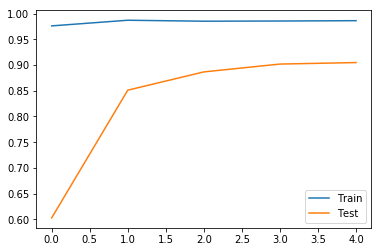

In [39]:
# Plot the learning curve.
train_scores = []
valid_scores = []

for train_ratio in np.arange(0.2,1.2,0.2):
    X_train, Y_train, X_valid, Y_valid = building_temp(0.84, train_ratio=train_ratio)
    # Do GridSearchCV to determine the best parameters.
    train_ind = np.arange(len(Y_train))
    X_tot = np.concatenate((X_train, X_valid), axis=0)
    Y_tot = np.concatenate((Y_train, Y_valid), axis=0)
    valid_ind = np.arange(len(Y_train), len(Y_tot))
    
    xgb_params = {
        'n_estimators': [100,400],
        'max_depth': [2,4,6],
        'eta': [0.3,0.6],
        'objective':['reg:squarederror'],
        'random_state':[10]}
    
    clf = GridSearchCV(XGB(), xgb_params, cv=[(train_ind, valid_ind)], n_jobs=4, verbose=10)\
                    .fit(X_tot,Y_tot)
    XGB_model = clf.best_estimator_
    
    # Train scores
    train_pred = XGB_model.predict(X_train)
    """

    rf_params = {
        'n_estimators': [100,400],
        'min_samples_split': [2,4],
        'min_samples_leaf': [1,2],
        'max_features': [0.3,0.6],
        'random_state':[10]}

    clf = GridSearchCV(RF(), rf_params, cv=[(train_ind, valid_ind)], n_jobs=4, verbose=10)\
                    .fit(X_tot,Y_tot)
    rf_model = clf.best_estimator_
    
    # Train scores
    train_pred = rf_model.predict(X_train)
    """
    
    
    train_scores.append(r2_score(Y_train, train_pred))
    # Valid scores
    valid_scores.append(clf.best_score_)
    print('Ratio {0:.1f} is finished'.format(train_ratio))
    
plt.plot(train_scores)
plt.plot(valid_scores)
plt.legend(['Train', 'Valid'])
plt.show()

In [40]:
valid_scores

[0.6028708015255257,
 0.8511252565558485,
 0.8866558871662229,
 0.9018771283449402,
 0.9047946551274645]

## For not automatically linear scaling

In [614]:
# best_params = {'n_estimators': 1000, 'random_state': 10, 'min_samples_leaf': 1, 'max_features': 0.35, 'min_samples_split': 4}
best_xgb_params = {'booster': 'gbtree', 'objective': 'reg:squarederror', 'n_estimators': 800, 'colsample_bynode': 0.5, 'subsample': 0.7, 'eta': 0.005, 'random_state': 10, 'max_depth': 4}
# best_xgb_params = {'booster': 'gbtree', 'objective': 'reg:squarederror', 'n_estimators': 2000, 'colsample_bynode': 0.3, 'subsample': 0.8, 'eta': 0.005, 'random_state': 10, 'max_depth': 2, 'reg_alpha':0.15}
# RF_model = RF(**best_params).fit(X_train, Y_train)
# KNN_model = KNN(n_neighbors=100,n_jobs=4).fit(X_train, Y_train)
XGB_model = XGB(**best_xgb_params).fit(X_train, Y_train)

In [615]:
# Calculate the linear transform directly
# Y_pred = RF_model.predict(X_train[-8000:])
Y_pred = XGB_model.predict(X_valid)
# Y_pred = XGB_model.predict(X_train[-8000:])
LR_model = LR().fit(Y_pred.reshape(-1,1), Y_valid.reshape(-1,1))
print('coefficient and intercept of linear model {}, {}'.format(LR_model.coef_, LR_model.intercept_))
print('r2_score {}'.format(r2_score(Y_valid, LR_model.predict(Y_pred.reshape(-1,1)))))

coefficient and intercept of linear model [[1.0158913]], [-161.79688]
r2_score 0.9595794547543515


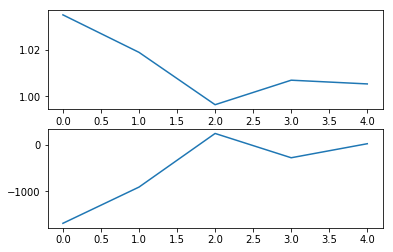

In [581]:

# Determine the best scaling.
coefs = []
intercepts = []

for num in np.arange(0, 29000, 6000):
    Y_pred = XGB_model.predict(X_train[num:num+6000])
    LR_model = LR().fit(Y_pred.reshape(-1,1), Y_train[num:num+6000].reshape(-1,1))
    coefs.append(LR_model.coef_[0][0])
    intercepts.append(LR_model.intercept_[0])

fig, ax = plt.subplots(2,1)
ax[0].plot(coefs)
ax[1].plot(intercepts)
plt.show()


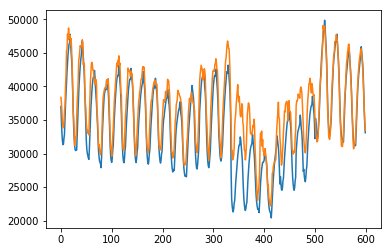

In [616]:
X_test = X_train[:600]
Y_test = Y_train[:600]

Y_ref = XGB_model.predict(X_test)
plt.plot(Y_test)
plt.plot(Y_ref)

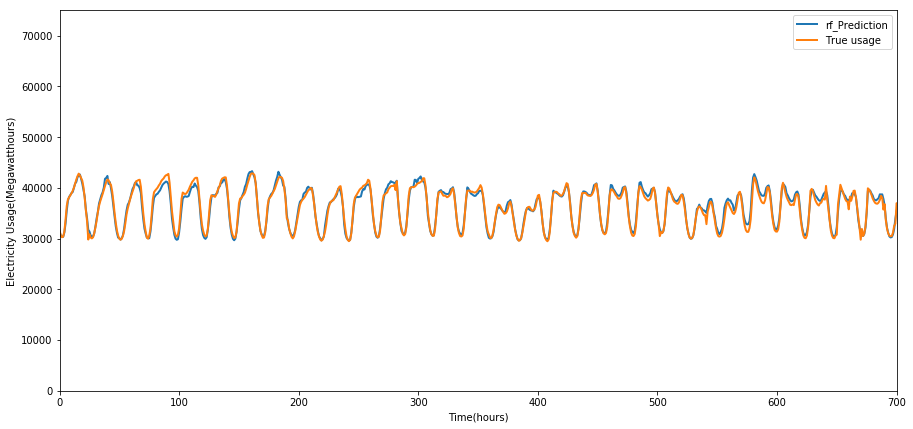

In [634]:

# Visualize the prediction.
X_visualize = X_valid[:]
Y_visualize = Y_valid[:]
plt.figure(figsize=(15,7))
# Y_predict_rf = RF_model.predict(X_visualize)
# Y_predict_knn = KNN_model.predict(X_visualize)
# Y_predict = my_estimator.predict(X_visualize, Y_visualize)
Y_predict_xgb = XGB_model.predict(X_visualize)

# plt.plot(LR_model.predict(Y_predict_rf.reshape(-1,1)), linewidth=2)
plt.plot(LR_model.predict(Y_predict_xgb.reshape(-1,1)), linewidth=2)
# plt.plot(Y_predict_knn*1.0434171+350, linewidth=4)
plt.plot(Y_visualize, linewidth=2)
# plt.plot(X_visualize[:,3]*100)
plt.xlabel('Time(hours)')
plt.ylabel('Electricity Usage(Megawatthours)')
plt.legend(['rf_Prediction','True usage'])
plt.xlim([0,700])
plt.ylim([0,75000])
plt.show()


### Construct a time series to predict the linear transform

In [618]:
# Save the random forest model
with open('models/xgb_pred_NW_2', 'wb') as file:
    pickle.dump(XGB_model, file)
# Save the linear regression model
with open('models/lr_correction_NW_2', 'wb') as file:
    pickle.dump(LR_model, file)

## For automatically linear scaling

In [42]:
my_estimator = elec_forcast(n_estimators=200, min_samples_split=2, min_samples_leaf=1, max_features=0.3, random_state=10).fit(X_train, Y_train)

In [43]:
Y_pred = my_estimator.predict(X_train, Y_train)
print('Num of train data: {}. Num of predictions: {}'.format(train_index, len(Y_pred)))

Num of train data: 35000. Num of predictions: 34976


In [458]:
# Perform grid search to look for the best parameters
'''
grid = {'n_estimators': [180,200,220],
       'min_samples_split': [2,4],
       'min_samples_leaf': [1,2],
       'max_features': [0.35,0.4,0.45],
       'random_state': [10]}


'''
xgb_grid = {'n_estimators': [800,1000,1200],
        'booster': ['gbtree'],
        'max_depth': [2,3,4],
        'eta': [0.005,0.01,0.02],
        'subsample': [0.7,0.8,0.9],
        'colsample_bynode': [0.3,0.5,0.7],
        'reg_lambda': [0],
        'reg_alpha': [0.15],
        'random_state': [10]
        }


max_r2 = -np.inf
best_params = None
best_beta = None
bar = tqdm_notebook(total=3*2*4*4*2**4)

for beta in [0.75,0.8,0.85]:
    X_train, Y_train, X_valid, Y_valid = building_temp(beta)
    train_end = len(X_train)
    valid_end = train_end+len(Y_valid)
    train_ind = np.arange(train_end)
    valid_ind = np.arange(train_end, valid_end)
    # Concatenate the train and validation set.
    X_total = np.concatenate((X_train, X_valid), axis=0)
    Y_total = np.concatenate((Y_train, Y_valid))
    search = GridSearchCV(elec_forcast_xgb(), xgb_grid, cv=[(train_ind, valid_ind)], n_jobs=4, verbose=10)
    search.fit(X_total, Y_total)
    # The best parameters.
    r2 = search.best_score_
    p = search.best_params_
    if max_r2 < r2:
        max_r2 = r2
        best_params = p
        best_beta = beta
    print('Best R2 score {} for {}.'.format(r2, beta))
    
    bar.update(2*4*4*2**4)
bar.close()
        
print('The maximum R2 score is: {} \n The best parameters are: {} \n The best beta is: {}'.format(max_r2, best_params, best_beta))

Fitting 1 folds for each of 243 candidates, totalling 243 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:   22.4s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:   35.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:  1.0min
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:  1.4min
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:  1.9min
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  2.4min
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:  3.1min
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:  3.6min
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:  4.4min
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:  5.3min
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:  6.7min
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:  7.8min
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:  9.4min
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed: 10.6min
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed: 12.4min
[Parallel(

Best R2 score 0.9399192652132251 for 0.75.
Fitting 1 folds for each of 243 candidates, totalling 243 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:   17.7s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:   29.9s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:   55.8s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:  1.3min
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:  1.7min
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  2.2min
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:  2.9min
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:  3.4min
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:  4.1min
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:  5.0min
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:  6.3min
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:  7.3min
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:  8.8min
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed: 10.0min
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed: 11.7min
[Parallel(

Best R2 score 0.9390328104609664 for 0.8.
Fitting 1 folds for each of 243 candidates, totalling 243 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:   18.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:   29.9s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:   55.7s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:  1.3min
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:  1.7min
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  2.2min
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:  2.9min
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:  3.4min
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:  4.1min
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:  5.0min
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:  6.3min
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:  7.3min
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:  8.8min
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed: 10.0min
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed: 11.7min
[Parallel(

Best R2 score 0.9379905101516105 for 0.85.

The maximum R2 score is: 0.9399192652132251 
 The best parameters are: {'reg_lambda': 0, 'booster': 'gbtree', 'reg_alpha': 0.15, 'n_estimators': 800, 'colsample_bynode': 0.5, 'subsample': 0.7, 'eta': 0.005, 'random_state': 10, 'max_depth': 4} 
 The best beta is: 0.75


In [411]:
best_params

{'max_features': 0.5,
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 200,
 'random_state': 10}

__Current best result__
The maximum R2 score is: 0.9482557022454389 
The best parameters are: {'reg_lambda': 0, 'reg_alpha': 0, 'n_estimators': 200, 'colsample_bynode': 0.7, 'subsample': 0.7, 'max_depth': 2, 'random_state': 10, 'eta': 0.2} 
The best beta is: 0.84

The maximum R2 score is: 0.9575326969695183 
 The best parameters are: {'booster': 'gbtree', 'n_estimators': 1000, 'colsample_bynode': 0.3, 'subsample': 0.7, 'eta': 0.1, 'random_state': 10, 'max_depth': 2} 
 The best beta is: 0.84
 
 The maximum R2 score is: 0.9507955372972503 
 The best parameters are: {'reg_lambda': 0, 'booster': 'gbtree', 'reg_alpha': 0.1, 'n_estimators': 800, 'colsample_bynode': 0.3, 'subsample': 0.8, 'eta': 0.08, 'random_state': 10, 'max_depth': 2} 
 The best beta is: 0.84
 
 The maximum R2 score is: 0.9532371853147704 
 The best parameters are: {'reg_lambda': 0, 'booster': 'gbtree', 'reg_alpha': 0.15, 'n_estimators': 500, 'colsample_bynode': 0.3, 'subsample': 0.8, 'eta': 0.04, 'random_state': 10, 'max_depth': 2} 
 The best beta is: 0.84
 
 The maximum R2 score is: 0.9557382439376924 
 The best parameters are: {'reg_lambda': 0, 'booster': 'gbtree', 'reg_alpha': 0.15, 'n_estimators': 300, 'colsample_bynode': 0.3, 'subsample': 0.8, 'eta': 0.005, 'random_state': 10, 'max_depth': 2} 
 The best beta is: 0.84

# Analyze the Present Data

In [480]:
# Load the electricity data from Sep 17 to Sep 24
elec_present = pd.read_csv('electricity_data/texas_sep_18.csv')

In [481]:
elec_present.head(1)

,Region Code,Timestamp (Hour Ending),Demand (MWh),Demand Forecast (MWh),Net Generation (MWh),Total Interchange (MWh)
0,TEX,9/16/2019 12 AM CDT,47548,47905.0,47125.0,-424.0


In [482]:
elec_present.columns

Index(['Region Code', 'Timestamp (Hour Ending)', 'Demand (MWh)',
       'Demand Forecast (MWh)', 'Net Generation (MWh)',
       'Total Interchange (MWh)'],
      dtype='object')

In [483]:
elec_present = elec_present.loc[:,['Timestamp (Hour Ending)', 'Demand (MWh)', 'Demand Forecast (MWh)']]

In [484]:
elec_present = elec_present.rename(columns={'Timestamp (Hour Ending)':'datetime','Demand (MWh)':'usage','Demand Forecast (MWh)':'prediction'})

In [485]:
elec_present['datetime'] = pd.to_datetime(elec_present['datetime'], format='%m/%d/%Y %I %p CDT')
elec_present['time'] = elec_present['datetime'].apply(lambda x:x.hour)
elec_present['month'] = elec_present['datetime'].apply(lambda x:x.month)
elec_present['weekday'] = elec_present['datetime'].apply(lambda x:x.weekday())
elec_present['year'] = elec_present['datetime'].apply(lambda x:x.year)
elec_present['day'] = elec_present['datetime'].apply(lambda x:x.day)

In [486]:
# Load the weather data
weather_sep_18 = pd.read_csv('electricity_data/weather_sep_18.csv')
# Round the date info
weather_sep_18['datetime'] = pd.to_datetime(weather_sep_18['DATE'], format='%Y-%m-%dT%H:%M:%S')
weather_sep_18['date'] = weather_sep_18['datetime'].apply(lambda date_time: round_time(date_time))
weather_sep_18['time'] = weather_sep_18['date'].apply(lambda x:x.hour)
weather_sep_18['month'] = weather_sep_18['date'].apply(lambda x:x.month)
weather_sep_18['day'] = weather_sep_18['date'].apply(lambda x:x.day)
# weather_sep_18['weekday'] = weather_sep_18['date'].apply(lambda x:x.weekday())
weather_sep_18['year'] = weather_sep_18['date'].apply(lambda x:x.year)
weather_sep_18['HourlyDryBulbTemperature'] = weather_sep_18['HourlyDryBulbTemperature'].apply(lambda s:parse_temperature(s))
weather_sep_18 = weather_sep_18.loc[weather_sep_18['HourlyDryBulbTemperature'].notna(),:]
weather_sep_18 = weather_sep_18[useful_columns]
weather_sep_18 = weather_sep_18[useful_columns].groupby(match_columns+['STATION'], as_index=False).mean()
houston = weather_sep_18.loc[weather_sep_18['STATION'] == 72243012960,:]
san_antonio = weather_sep_18.loc[weather_sep_18['STATION'] == 72259003927,:]
dallas = weather_sep_18.loc[weather_sep_18['STATION'] == 72253012921,:]
df_sep_18 = elec_present.merge(houston, how='inner', left_on=match_columns, right_on=match_columns)
df_sep_18 = df_sep_18.merge(san_antonio, how='inner', left_on=match_columns, right_on=match_columns)
df_sep_18 = df_sep_18.merge(dallas, how='inner', left_on=match_columns, right_on=match_columns)
df_sep_18 = df_sep_18.drop(columns=['STATION_x', 'STATION_y', 'STATION']).rename(columns={'HourlyDryBulbTemperature_x':'T_1','HourlyDryBulbTemperature_y':'T_3','HourlyDryBulbTemperature':'T_2'})
df_sep_18 = df_sep_18.sort_values('datetime')

In [487]:
df_sep_18.head(1)

,datetime,usage,prediction,time,month,weekday,year,day,T_1,T_3,T_2
0,2019-09-16,47548,47905.0,0,9,0,2019,16,76.0,83.0,79.0


In [488]:
X_present = df_sep_18[features].values
Y_present = df_sep_18['usage'].values
column = 3
X_present, Y_present = attenuate(X_present, Y_present, beta, column)
Y_web_pred = df_sep_18['prediction'].values[25:]

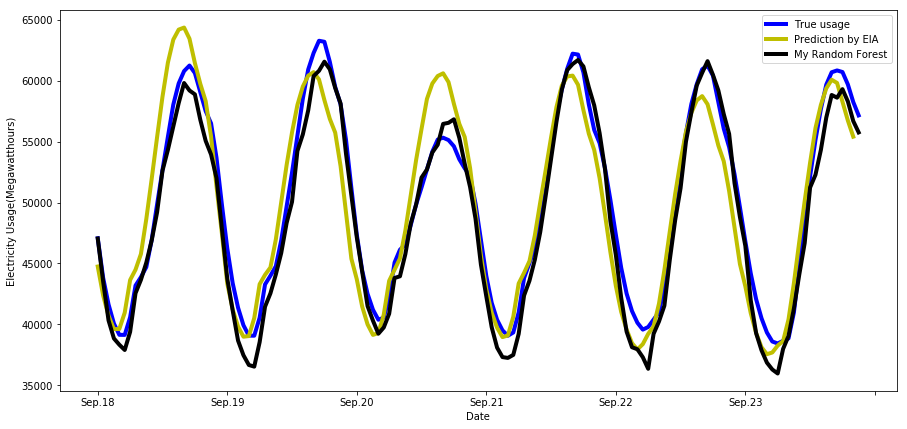

In [492]:
from matplotlib.ticker import MultipleLocator

Y_pred = XGB_model.predict(X_present)
# Y_pred = RF_model.predict(X_present)
fig,ax = plt.subplots(figsize=(15,7))
plt.plot(Y_present, 'b', linewidth=4)
plt.plot(Y_web_pred, 'y', linewidth=4)
plt.plot(Y_pred*1.07368297-420, 'black', linewidth=4)
plt.xlabel('Date')
plt.ylabel('Electricity Usage(Megawatthours)')
plt.legend(['True usage', 'Prediction by EIA', 'My Random Forest'])
ax.xaxis.set_major_locator(MultipleLocator(24))
ax.set_xticklabels(['', 'Sep.18', 'Sep.19', 'Sep.20', 'Sep.21', 'Sep.22', 'Sep.23'])
plt.show()

## Time Series Model

In [496]:
electricity_demand_sorted = electricity_demand.sort_values(['datetime']).reset_index(drop=True)

In [497]:
electricity_demand_sorted.head(3)

,datetime,usage,time,month,weekday,year,day,normalized_usage
0,2015-07-01 01:06:00,12775,1,7,2,2015,1,0.000000
1,2015-07-01 02:06:00,34914,2,7,2,2015,1,0.480197
2,2015-07-01 03:06:00,33142,3,7,2,2015,1,0.441762


In [498]:
# Make sure there is no missed hours.
wrong_intervals = []

for ind in np.arange(len(electricity_demand_sorted)-1):
    if electricity_demand_sorted.iloc[ind]['datetime']+timedelta(hours=1) != electricity_demand_sorted.iloc[ind+1]['datetime']:
        wrong_intervals.append(ind)

In [499]:
print('Wrong intervals: {}'.format(len(wrong_intervals)))

Wrong intervals: 8


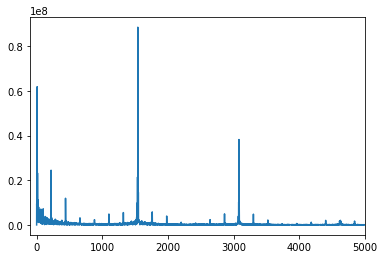

In [78]:
mean_removed = electricity_demand_sorted['usage'].values - np.mean(electricity_demand_sorted['usage'].values)
fft = np.absolute(np.fft.fft(mean_removed))
plt.plot(fft)
_ = plt.xlim([-100,5000])

In [113]:
# Peak for the daily cycle
daily_peak = np.where((fft < -3e7) | (fft > 1e7))[0]
print('the preak corresponding to the daily cycle: {}'.format(daily_peak))

the preak corresponding to the daily cycle: [    4     7     8     9    10    13    18   220   440  1536  1537  1541
  1545  1549  3078  3082 33900 33904 35433 35437 35441 35445 35446 36542
 36762 36964 36969 36972 36973 36974 36975 36978]


3 corresponding to something around 1.4 year
4 corresponding to something around 1.05 year
8 corresponding to something around 0.53 year ->
9 corresponding to something around 0.46 year -> These two should be corresponding to the half a year period (check whether there are pseudo periods)
220 corresponding to the weekly period (not that strong compared to the daily peak)
1539 corresponding to the daily period

## Check to see how many harmonics we should include

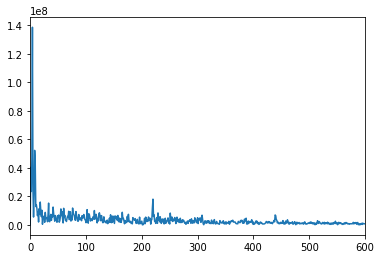

In [647]:
plt.plot(fft)
_ = plt.xlim([0,600])

Let's fit a periodic model first.<br>
three harmonics for the yearly cycle and two harmonics for the weekly and daily cycle.<br>
Try the first three years as the training set first

In [500]:
df_for_periodic_model = df_joined[['datetime','usage','time','month','weekday','year','day']].copy()

In [501]:
def diff_in_hours(x):
    # This function returns the number of hours from 2015-07-01 01:05:00
    minutes = (x-datetime(2015, 7, 1, 1, 5, 0)).total_seconds()/60
    if minutes % 60 > 30:
        return minutes/60 + 1
    else:
        return minutes/60
    
df_for_periodic_model['hours'] = df_for_periodic_model['datetime'].apply(lambda x: diff_in_hours(x))

In [502]:
# Construct the sin and cos columns.
def trig(func, period, x):
    # This function returns a sin or x value of x.
    return func(2*np.pi*x/period)

# Yearly period.
df_for_periodic_model['yearly_sin'] = df_for_periodic_model['hours'].apply(lambda x: trig(np.sin, 365.25*24, x))
df_for_periodic_model['yearly_cos'] = df_for_periodic_model['hours'].apply(lambda x: trig(np.cos, 365.25*24, x))
df_for_periodic_model['yearly_2_sin'] = df_for_periodic_model['hours'].apply(lambda x: trig(np.sin, 365.25*24/2, x)) # Starting from here are harmonics
df_for_periodic_model['yearly_2_cos'] = df_for_periodic_model['hours'].apply(lambda x: trig(np.cos, 365.25*24/2, x))
df_for_periodic_model['yearly_3_sin'] = df_for_periodic_model['hours'].apply(lambda x: trig(np.sin, 365.25*24/3, x))
df_for_periodic_model['yearly_3_cos'] = df_for_periodic_model['hours'].apply(lambda x: trig(np.cos, 365.25*24/3, x))
df_for_periodic_model['yearly_4_sin'] = df_for_periodic_model['hours'].apply(lambda x: trig(np.sin, 365.25*24/4, x))
df_for_periodic_model['yearly_4_cos'] = df_for_periodic_model['hours'].apply(lambda x: trig(np.cos, 365.25*24/4, x))
# Weekly period.
df_for_periodic_model['weekly_sin'] = df_for_periodic_model['hours'].apply(lambda x: trig(np.sin, 7*24, x))
df_for_periodic_model['weekly_cos'] = df_for_periodic_model['hours'].apply(lambda x: trig(np.cos, 7*24, x))
df_for_periodic_model['weekly_2_sin'] = df_for_periodic_model['hours'].apply(lambda x: trig(np.sin, 7*24/2, x))
df_for_periodic_model['weekly_2_cos'] = df_for_periodic_model['hours'].apply(lambda x: trig(np.cos, 7*24/2, x))
df_for_periodic_model['weekly_3_sin'] = df_for_periodic_model['hours'].apply(lambda x: trig(np.sin, 7*24/3, x))
df_for_periodic_model['weekly_3_cos'] = df_for_periodic_model['hours'].apply(lambda x: trig(np.cos, 7*24/3, x))
df_for_periodic_model['weekly_4_sin'] = df_for_periodic_model['hours'].apply(lambda x: trig(np.sin, 7*24/4, x))
df_for_periodic_model['weekly_4_cos'] = df_for_periodic_model['hours'].apply(lambda x: trig(np.cos, 7*24/4, x))
df_for_periodic_model['weekly_5_sin'] = df_for_periodic_model['hours'].apply(lambda x: trig(np.sin, 7*24/5, x))
df_for_periodic_model['weekly_5_cos'] = df_for_periodic_model['hours'].apply(lambda x: trig(np.cos, 7*24/5, x))
# Dayly period.
df_for_periodic_model['dayly_sin'] = df_for_periodic_model['hours'].apply(lambda x: trig(np.sin, 24, x))
df_for_periodic_model['dayly_cos'] = df_for_periodic_model['hours'].apply(lambda x: trig(np.cos, 24, x))
df_for_periodic_model['dayly_2_sin'] = df_for_periodic_model['hours'].apply(lambda x: trig(np.sin, 24/2, x))
df_for_periodic_model['dayly_2_cos'] = df_for_periodic_model['hours'].apply(lambda x: trig(np.cos, 24/2, x))
df_for_periodic_model['dayly_3_sin'] = df_for_periodic_model['hours'].apply(lambda x: trig(np.sin, 24/3, x))
df_for_periodic_model['dayly_3_cos'] = df_for_periodic_model['hours'].apply(lambda x: trig(np.cos, 24/3, x))
df_for_periodic_model['dayly_4_sin'] = df_for_periodic_model['hours'].apply(lambda x: trig(np.sin, 24/4, x))
df_for_periodic_model['dayly_4_cos'] = df_for_periodic_model['hours'].apply(lambda x: trig(np.cos, 24/4, x))
df_for_periodic_model['dayly_5_sin'] = df_for_periodic_model['hours'].apply(lambda x: trig(np.sin, 24/5, x))
df_for_periodic_model['dayly_5_cos'] = df_for_periodic_model['hours'].apply(lambda x: trig(np.cos, 24/5, x))

In [503]:
df_for_periodic_model.head(3)

,datetime,usage,time,month,weekday,year,day,hours,yearly_sin,yearly_cos,yearly_2_sin,yearly_2_cos,yearly_3_sin,yearly_3_cos,yearly_4_sin,yearly_4_cos,weekly_sin,weekly_cos,weekly_2_sin,weekly_2_cos,weekly_3_sin,weekly_3_cos,weekly_4_sin,weekly_4_cos,weekly_5_sin,weekly_5_cos,dayly_sin,dayly_cos,dayly_2_sin,dayly_2_cos,dayly_3_sin,dayly_3_cos,dayly_4_sin,dayly_4_cos,dayly_5_sin,dayly_5_cos
0,2015-07-01 01:06:00,12775,1,7,2,2015,1,0.016667,0.000012,1.000000,0.000024,1.000000,0.000036,1.000000,0.000048,1.000000,0.000623,1.000000,0.001247,0.999999,0.001870,0.999998,0.002493,0.999997,0.003117,0.999995,0.004363,0.999990,0.008727,0.999962,0.013090,0.999914,0.017452,0.999848,0.021815,0.999762
1,2015-07-01 02:06:00,34914,2,7,2,2015,1,1.016667,0.000729,1.000000,0.001457,0.999999,0.002186,0.999998,0.002915,0.999996,0.038014,0.999277,0.075973,0.997110,0.113823,0.993501,0.151507,0.988456,0.188973,0.981982,0.263031,0.964787,0.507538,0.861629,0.716302,0.697790,0.874620,0.484810,0.971342,0.237686
2,2015-07-01 03:06:00,33142,3,7,2,2015,1,2.016667,0.001445,0.999999,0.002891,0.999996,0.004336,0.999991,0.005782,0.999983,0.075352,0.997157,0.150275,0.988644,0.224344,0.974510,0.297137,0.954835,0.368240,0.929731,0.503774,0.863836,0.870356,0.492424,0.999914,-0.013090,0.857167,-0.515038,0.480989,-0.876727


There is a slowly varying trend which should be handled first using a ridge regression.

In [504]:
df_for_periodic_model.tail(1)

,datetime,usage,time,month,weekday,year,day,hours,yearly_sin,yearly_cos,yearly_2_sin,yearly_2_cos,yearly_3_sin,yearly_3_cos,yearly_4_sin,yearly_4_cos,weekly_sin,weekly_cos,weekly_2_sin,weekly_2_cos,weekly_3_sin,weekly_3_cos,weekly_4_sin,weekly_4_cos,weekly_5_sin,weekly_5_cos,dayly_sin,dayly_cos,dayly_2_sin,dayly_2_cos,dayly_3_sin,dayly_3_cos,dayly_4_sin,dayly_4_cos,dayly_5_sin,dayly_5_cos
36620,2019-09-18 22:06:00,40510,22,9,2,2019,18,36981.016667,0.980709,0.195474,0.383406,-0.92358,-0.830817,-0.556546,-0.708212,0.705999,0.707547,0.706666,0.999999,-0.001247,0.705783,-0.708428,-0.002493,-0.999997,-0.709307,-0.7049,-0.704015,0.710185,-0.999962,0.008727,-0.716302,-0.69779,-0.017452,-0.999848,0.691513,-0.722364


In [505]:
# Produce the x^2 and X^3 term for the ridge regressor

df_for_periodic_model['scaled_hours'] = df_for_periodic_model['hours']/100
df_for_periodic_model['scaled_hours_squared'] = df_for_periodic_model['scaled_hours']**2
df_for_periodic_model['scaled_hours_cubic'] = df_for_periodic_model['scaled_hours']**3

In [506]:
columns_x = ['scaled_hours', 'scaled_hours_squared', 'scaled_hours_cubic']
X = df_for_periodic_model[columns_x].values
y = df_for_periodic_model['usage'].values/1e4

In [507]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression

# search = GridSearchCV(Line, params, cv=5, n_jobs=4, verbose=10)
# _ = search.fit(X,y)
linear_trend = LinearRegression().fit(X[:,0].reshape(-1,1), y)

In [508]:
# Save the linear trend model.
with open('models/lr_yearly_trend_NW_2', 'wb') as file:
    pickle.dump(linear_trend, file)
print(linear_trend.coef_, linear_trend.intercept_)

[0.00050237] 3.8357097603012535


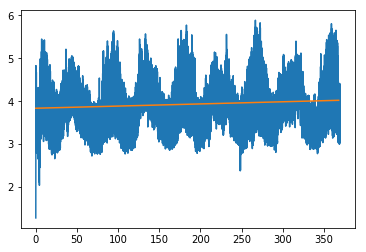

In [509]:
plt.plot(X[:,0],y)
X_sample = np.arange(int(X[-1,0]))
_ = plt.plot(X_sample, linear_trend.predict(X_sample.reshape(-1,1)))
# plt.xlim([10,20])

In [696]:
def remove_trend(row):
    return row['usage']-(row['scaled_hours']*linear_trend.coef_[0]+linear_trend.intercept_)*1e4

df_for_periodic_model['usage_trend_removed'] = df_for_periodic_model[['usage','scaled_hours']].apply(lambda row: remove_trend(row), axis=1)

# Split the train, test and validation set

df_train = df_for_periodic_model.iloc[:train_index]
df_valid = df_for_periodic_model.iloc[scaling_index:]
df_test = df_for_periodic_model.iloc[train_index:]

In [697]:
df_train.head(1)

,datetime,usage,time,month,weekday,year,day,hours,yearly_sin,yearly_cos,yearly_2_sin,yearly_2_cos,yearly_3_sin,yearly_3_cos,yearly_4_sin,yearly_4_cos,weekly_sin,weekly_cos,weekly_2_sin,weekly_2_cos,weekly_3_sin,weekly_3_cos,weekly_4_sin,weekly_4_cos,weekly_5_sin,weekly_5_cos,dayly_sin,dayly_cos,dayly_2_sin,dayly_2_cos,dayly_3_sin,dayly_3_cos,dayly_4_sin,dayly_4_cos,dayly_5_sin,dayly_5_cos,scaled_hours,scaled_hours_squared,scaled_hours_cubic,usage_trend_removed
0,2015-07-01 01:06:00,12775,1,7,2,2015,1,0.016667,0.000012,1.0,0.000024,1.0,0.000036,1.0,0.000048,1.0,0.000623,1.0,0.001247,0.999999,0.00187,0.999998,0.002493,0.999997,0.003117,0.999995,0.004363,0.99999,0.008727,0.999962,0.01309,0.999914,0.017452,0.999848,0.021815,0.999762,0.000167,2.777778e-08,4.629630e-12,-25582.09844


In [698]:
columns_x = []
for column in df_train.columns:
    if column.endswith('sin') or column.endswith('cos'):
        columns_x.append(column)

In [699]:
X = df_train[columns_x].values
y = df_train['usage_trend_removed'].values

period_model = LinearRegression().fit(X,y)

In [700]:
# Save the periodic model.
with open('models/lr_periodic_NW_2', 'wb') as file:
    pickle.dump(period_model, file)
period_model.coef_

array([  531.604561  , -1033.28561463,  2360.82003815,  2925.69219189,
         859.36691417,  -183.72438876,  -380.70754132,  -172.91772394,
         529.02901143,  1251.76567591,  -600.00763979,  -371.90535769,
         208.67669704,   -94.2858181 ,   194.90506974,    39.05669281,
        -280.03005311,   161.04639079, -3753.32726007, -2773.32719528,
       -2067.57414198,  -690.22847393,    17.82463483,    23.26050939,
         209.31962494,  -116.26947672,   -49.78956939,  -181.09339298])

0.7365959325854675

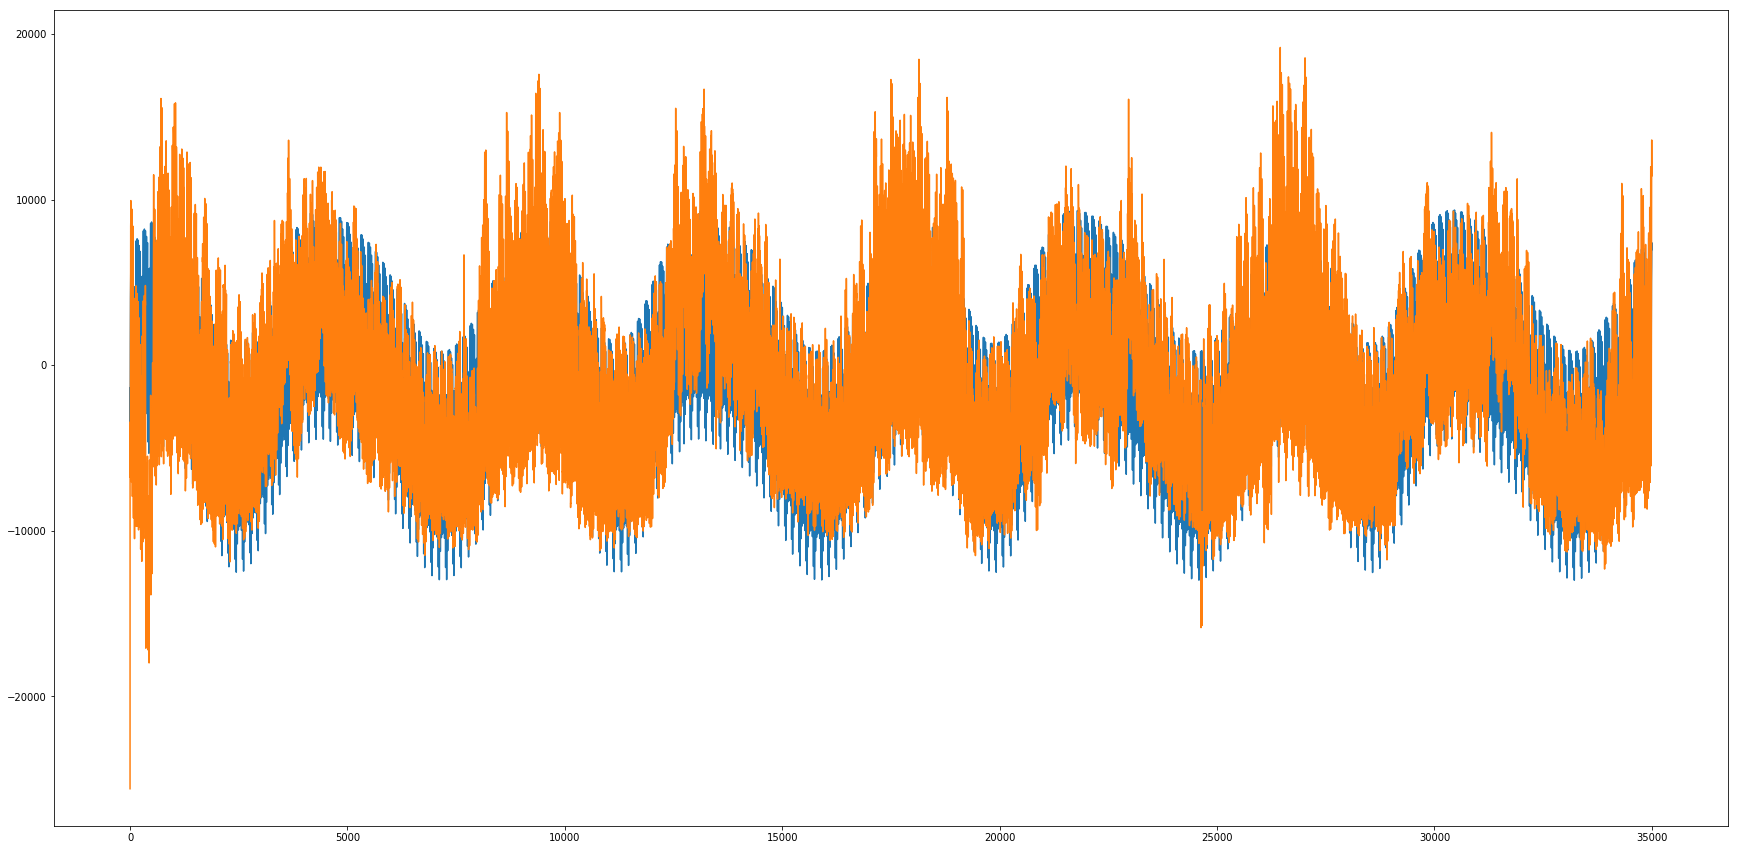

In [701]:
from sklearn.metrics import r2_score

# Plot the prediction for the train data
#df_valid = df_valid.reset_index(drop=True)
samples_X = df_train.loc[:, columns_x].values
samples_Y = df_train.loc[:, 'usage_trend_removed'].values
train_pred = period_model.predict(samples_X)
df_train['prediction'] = train_pred

plt.subplots(figsize=(30,15))
plt.plot(train_pred)
_ = plt.plot(samples_Y)

r2_score(samples_Y, train_pred)

Notice that the amplitude in summer is larger than the amplitude in winter. Fit a linear regression to each days true usage and prediction.

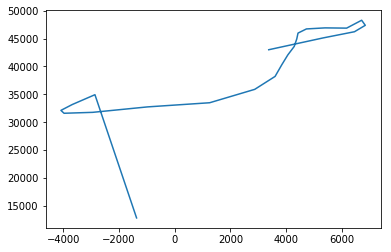

In [702]:
# plot the prediction and true usage for a specific day as an example.
x = df_train.loc[df_train['datetime'] < datetime(2015,7,2,0,0,0), ['usage','prediction']].values
y = x[:,0]
x = x[:,1]
plt.plot(x,y)
plt.show()

In [703]:
from datetime import date

df_train['date'] = df_train['datetime'].apply(lambda x: date(x.year, x.month, x.day))

In [704]:
# aggregate by day.
train_truths = df_train[['date','usage_trend_removed']].groupby(['date'])['usage_trend_removed'].apply(list)
train_preds = df_train[['date','prediction']].groupby(['date'])['prediction'].apply(list)

In [705]:
def linear_adjustment(X,y):
    lr_tool = LR().fit(np.asarray(X).reshape(-1,1),np.asarray(y).reshape(-1,1))
    return lr_tool.coef_[0][0], lr_tool.intercept_

In [706]:
adjustment_coefs = []
adjustment_intercepts = []
for X,y in zip(train_preds, train_truths):
    coef, intercept = linear_adjustment(X,y)
    adjustment_coefs.append(coef)
    adjustment_intercepts.append(intercept)

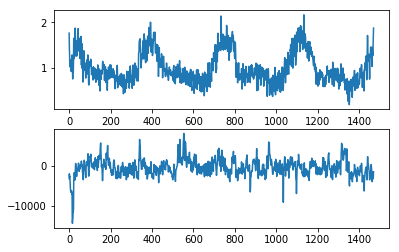

In [707]:
fig, ax = plt.subplots(2,1)
ax[0].plot(adjustment_coefs)
ax[1].plot(adjustment_intercepts)
plt.show()

In [708]:
# Fit three harmonics to both the coeficients and the intercepts.
sin = np.sin(np.arange(len(train_truths))*2*np.pi/365.25).reshape(-1,1)
cos = np.cos(np.arange(len(train_truths))*2*np.pi/365.25).reshape(-1,1)
sin_2 = np.sin(np.arange(len(train_truths))*np.pi/365.25).reshape(-1,1)
cos_2 = np.cos(np.arange(len(train_truths))*np.pi/365.25).reshape(-1,1)
sin_3 = np.sin(np.arange(len(train_truths))*2*np.pi/365.25/3).reshape(-1,1)
cos_3 = np.cos(np.arange(len(train_truths))*2*np.pi/365.25/3).reshape(-1,1)
sin_4 = np.sin(np.arange(len(train_truths))*2*np.pi/365.25/4).reshape(-1,1)
cos_4 = np.cos(np.arange(len(train_truths))*2*np.pi/365.25/4).reshape(-1,1)

In [709]:
X = np.concatenate((sin,cos,sin_2,cos_2,sin_3,cos_3), axis=1)

lr_coef = LinearRegression().fit(X, adjustment_coefs)
lr_intercept = LinearRegression().fit(X, adjustment_intercepts)

# Save the linear adjustment models.
with open('models/lr_adjustement_coef_NW_2', 'wb') as file:
    pickle.dump(lr_coef, file)
    
with open('models/lr_adjustement_intercept_NW_2', 'wb') as file:
    pickle.dump(lr_intercept, file)

In [710]:
df_train.head(1)

,datetime,usage,time,month,weekday,year,day,hours,yearly_sin,yearly_cos,yearly_2_sin,yearly_2_cos,yearly_3_sin,yearly_3_cos,yearly_4_sin,yearly_4_cos,weekly_sin,weekly_cos,weekly_2_sin,weekly_2_cos,weekly_3_sin,weekly_3_cos,weekly_4_sin,weekly_4_cos,weekly_5_sin,weekly_5_cos,dayly_sin,dayly_cos,dayly_2_sin,dayly_2_cos,dayly_3_sin,dayly_3_cos,dayly_4_sin,dayly_4_cos,dayly_5_sin,dayly_5_cos,scaled_hours,scaled_hours_squared,scaled_hours_cubic,usage_trend_removed,prediction,date
0,2015-07-01 01:06:00,12775,1,7,2,2015,1,0.016667,0.000012,1.0,0.000024,1.0,0.000036,1.0,0.000048,1.0,0.000623,1.0,0.001247,0.999999,0.00187,0.999998,0.002493,0.999997,0.003117,0.999995,0.004363,0.99999,0.008727,0.999962,0.01309,0.999914,0.017452,0.999848,0.021815,0.999762,0.000167,2.777778e-08,4.629630e-12,-25582.09844,-1371.789225,2015-07-01


In [711]:
df_train['adjusted_pred'] = df_train['prediction']* \
                            lr_coef.predict(df_train[columns_x[:6]].values).reshape(-1) \
                            + lr_intercept.predict(df_train[columns_x[:6]].values).reshape(-1)

r2_score: 0.7468397905893721


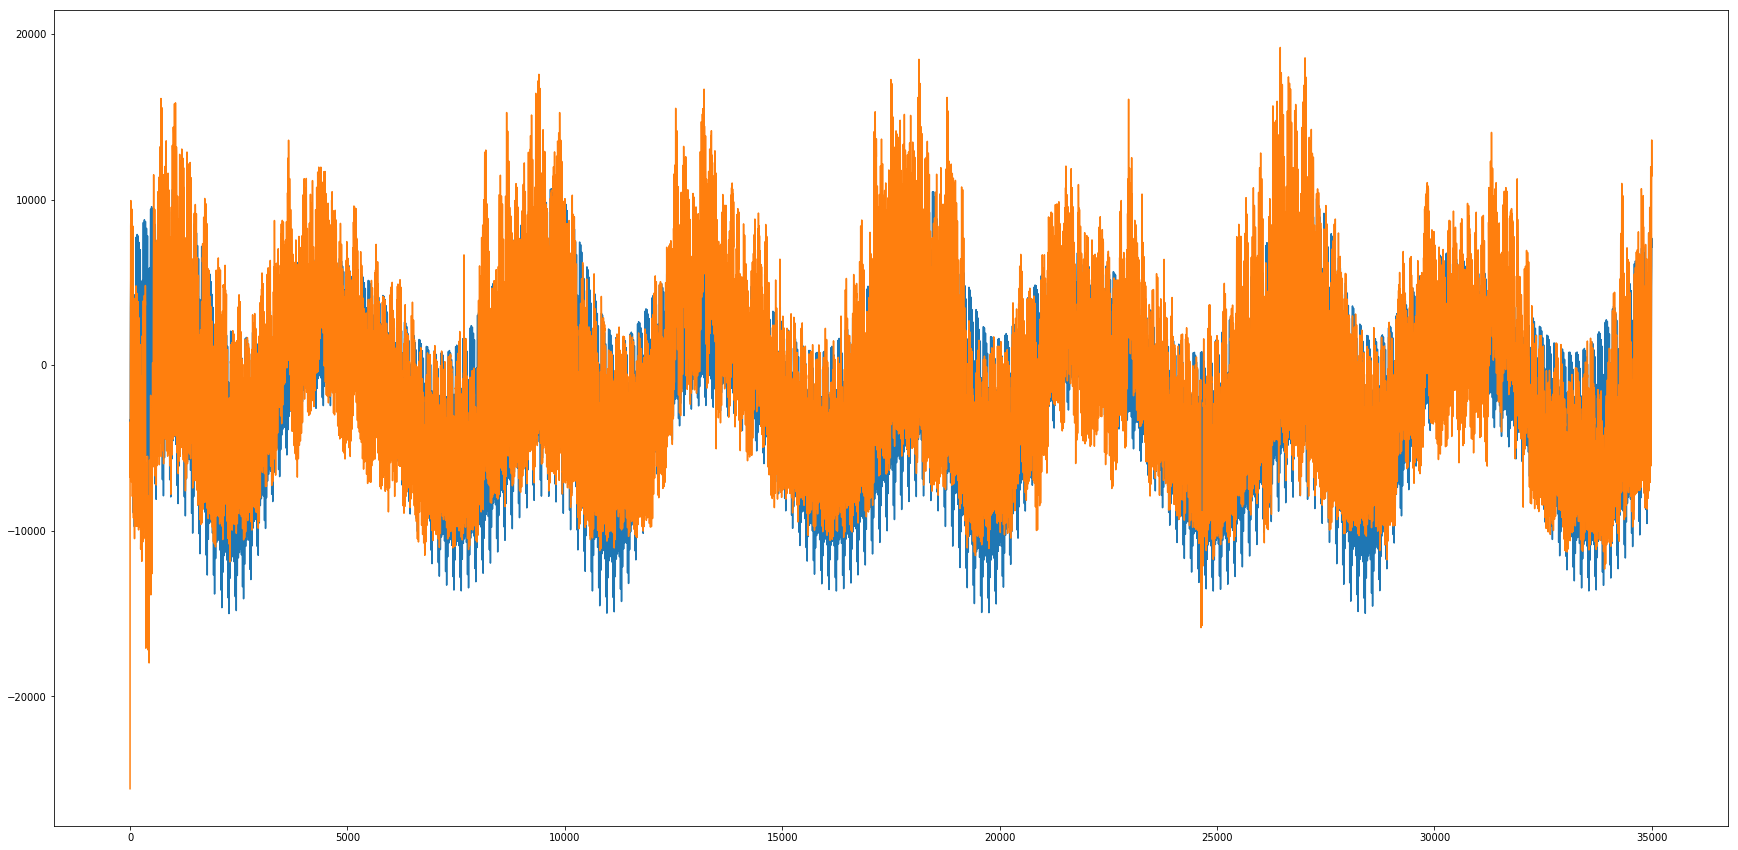

In [712]:
plt.subplots(figsize=(30,15))
plt.plot(df_train['adjusted_pred'].values)
_ = plt.plot(df_train['usage_trend_removed'].values)
print('r2_score: {}'.format(r2_score(df_train['usage_trend_removed'], df_train['adjusted_pred'])))

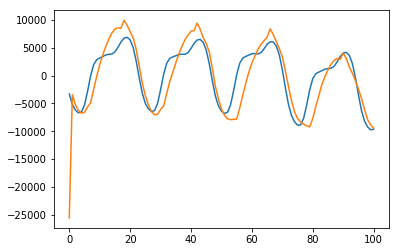

In [713]:
# plot the prediction for the validation data.

# plt.subplots(figsize=(30,15))
plt.plot(df_train.loc[:100, 'adjusted_pred'].values)
_ = plt.plot(df_train.loc[:100, 'usage_trend_removed'].values)

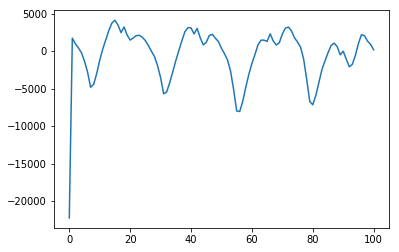

In [714]:
# Plot the residual.
df_train['residual'] = df_train['usage_trend_removed']-df_train['adjusted_pred']
# plt.subplots(figsize=(30,15))
_ = plt.plot(df_train.loc[:100, 'usage_trend_removed'].values-df_train.loc[:100, 'adjusted_pred'].values)

Try auto correlation and partial autocorrelation in the residual to make new discovery.

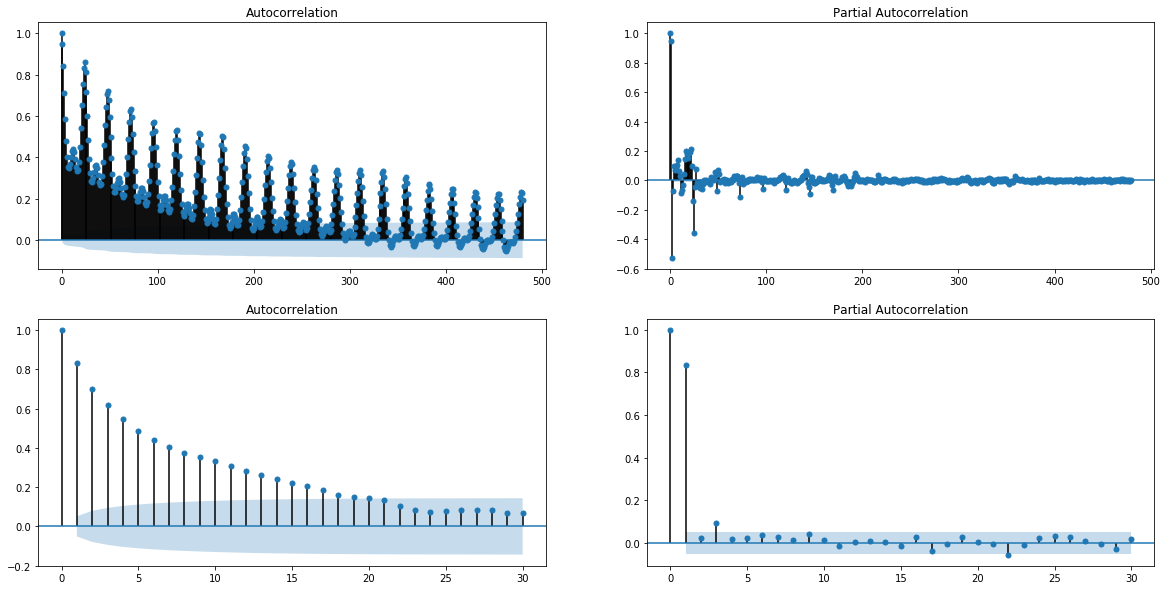

In [715]:
# Autocorrelation and partial autocorrelation of the residual and the residual grouped by hours.

fig, ax = plt.subplots(2,2, figsize=(20,10))
_ = plot_acf(x=df_train['residual'].values, ax=ax[0,0],lags=480)
_ = plot_pacf(x=df_train['residual'].values, ax=ax[0,1], lags=480)
_ = plot_acf(x=df_train.loc[df_train['time'] == 12, 'residual'].values, ax=ax[1,0], lags=30)
_ = plot_pacf(x=df_train.loc[df_train['time'] == 12, 'residual'].values, ax=ax[1,1], lags=30)

upper: 3401.0. lower: -3567.0


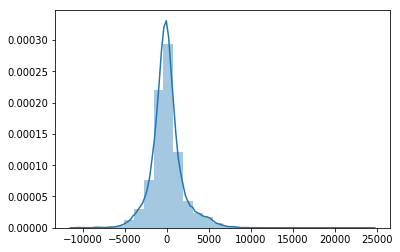

In [716]:
# Construct the distribution of the first order daily differences.
diffs = []
residuals = []
for h in np.arange(24):
    diffs.extend(np.diff(df_train.loc[df_train['time'] == h, 'usage'].values))
    residuals.extend(df_train.loc[df_train['time'] == h, 'residual'].values)

# Boundaries for outliers
qs = np.percentile(diffs, [25,75])
one_q = qs[0]
three_q = qs[1]
upper = 1.5*(three_q-one_q)+three_q
lower = one_q-1.5*(three_q-one_q)
print('upper: {}. lower: {}'.format(upper, lower))
_ = sns.distplot(diffs, bins=30)

In [717]:
# Construct kind of an AR(2) model with data containing outliers removed.
residuals = np.asarray(residuals).reshape(-1,1)
x = np.concatenate((residuals[:-2,:], residuals[1:-1,:], residuals[2:,:]), axis=1)
diffs_x = np.maximum(np.absolute(x[:,1]-x[:,0]), np.absolute(x[:,2]-x[:,1]))

x = x[diffs_x < (upper-lower)/2]
y = x[:,2]
x = x[:,:2]

lr_ar2 = LinearRegression(fit_intercept=False).fit(x,y)
print('Parameters: {}, {}'.format(lr_ar2.coef_, lr_ar2.intercept_))
print('r2_score: {}'.format(r2_score(y,lr_ar2.predict(x))))

Parameters: [-0.10112999  0.99351225], 0.0
r2_score: 0.8193974632389694


In [718]:
# Save the AR(2) model.
with open('models/lr_ar2_NW_2', 'wb') as file:
    pickle.dump(lr_ar2, file)

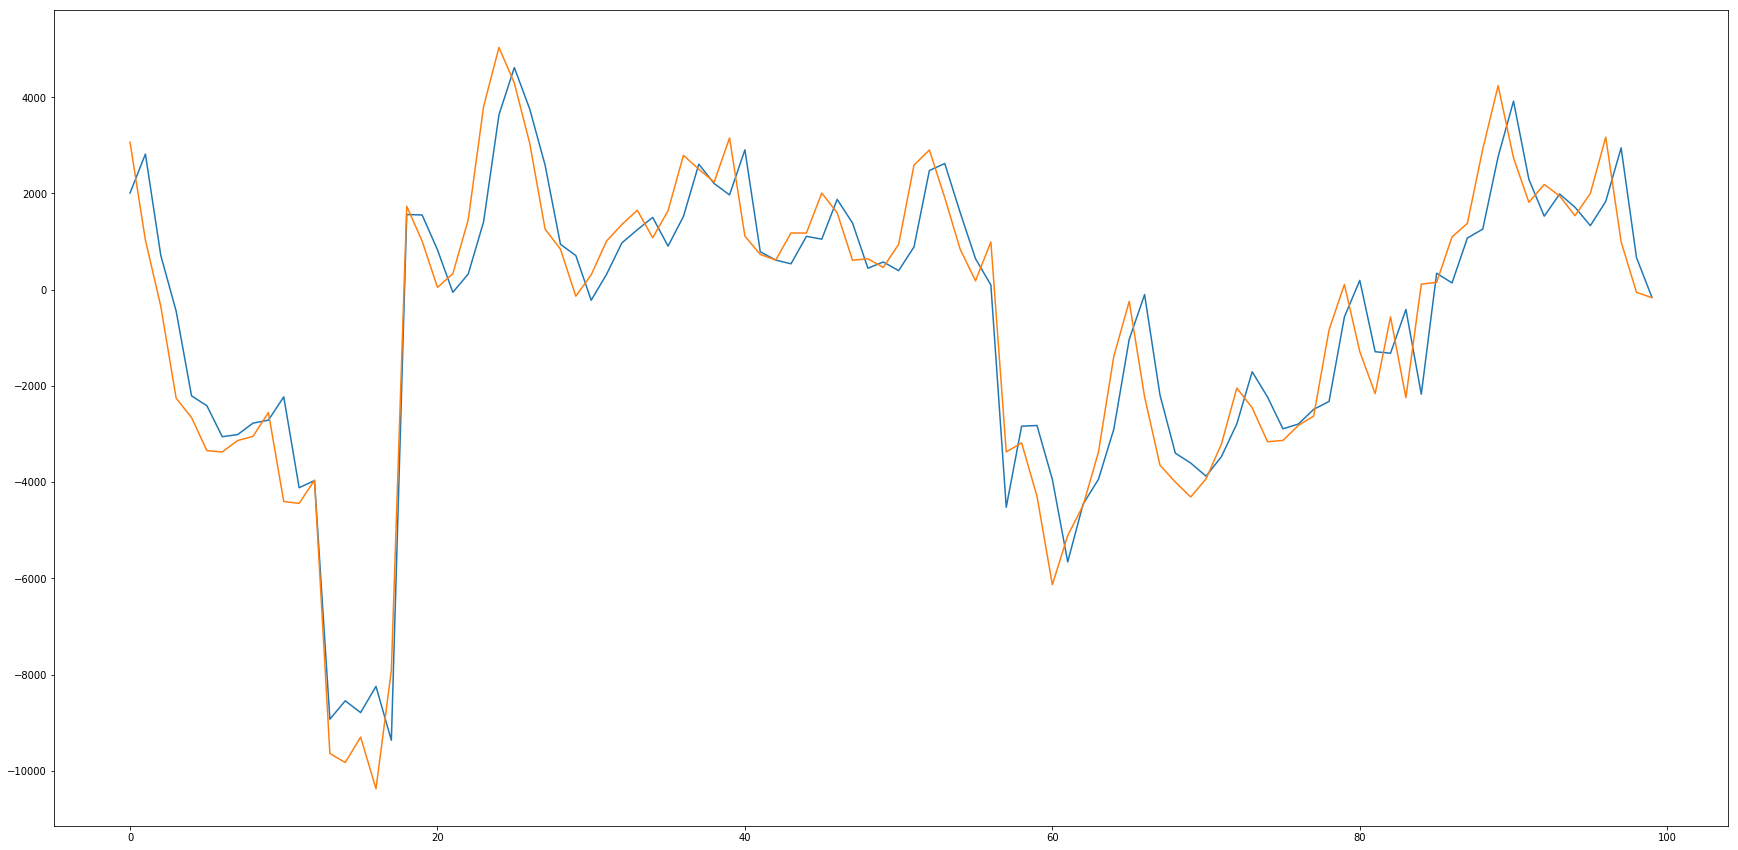

In [719]:
x_preds = lr_ar2.predict(x)
plt.subplots(figsize=(30,15))
plt.plot(x_preds[:100])
_ = plt.plot(y[:100])

## Test the time series model on the validation set.

In [720]:
df_valid['prediction'] = period_model.predict(df_valid[columns_x].values)
df_valid['adjusted_pred'] = df_valid['prediction']* \
                            lr_coef.predict(df_valid[columns_x[:6]].values).reshape(-1) \
                            + lr_intercept.predict(df_valid[columns_x[:6]].values).reshape(-1)

In [721]:
df_valid = df_valid.reset_index().rename(columns={'Unnamed: 0': 'index'})
# df_valid = df_valid.drop(columns=['index']).reset_index(drop=True).reset_index().rename(columns={'Unnamed: 0': 'index'})

In [722]:
df_valid['residual'] = df_valid['usage_trend_removed']-df_valid['adjusted_pred']

In [723]:
def predict_residual(df):
    # Predict the residual of the periodic model.
    residual_pred = np.asarray([[-1,-1,-1,-1]])

    for h in np.arange(24):
        # make predictions.
        x = df.loc[df['time'] == h, ['index', 'residual']].values
        index = x[2:,0].reshape(-1,1)
        x = np.concatenate((x[0:-2,1].reshape(-1,1), x[1:-1,1].reshape(-1,1)), axis=1)
        y = lr_ar2.predict(x)

        # go through the list and correct the days with sudden weather change with the previous prediction values.
        # which means we don't alter our prediction facing a sudden weather change, unless the change persists for two days.
        # for ind in np.arange(1, len(x)):
          #  if abs(x[ind,1]-x[ind,0]) > (upper-lower)/2:
           #     y[ind] = y[ind-1]

        y = np.concatenate((index, y.reshape(-1,1), x), axis=1)
        residual_pred = np.concatenate((residual_pred,y), axis=0)

    return pd.DataFrame(residual_pred, columns=['index','residual_pred','t_2', 't_1'])

In [724]:
df_joined = df_joined.reset_index(drop=True)
X_temp_valid = df_joined[features[3:]].values[scaling_index:,:]
index = np.arange(48+scaling_index, scaling_index+len(X_temp_valid))
x, y = attenuate(df_joined.loc[scaling_index:,features].values, df_joined.loc[scaling_index:,'usage'].values, 0.84, 3)
# Y_pred_valid = LR_model.predict(XGB_model.predict(x).reshape(-1,1))
Y_pred_valid = XGB_model.predict(x).reshape(-1,1)
X_temp_valid = np.concatenate((index.reshape(-1,1), X_temp_valid[48:,:], X_temp_valid[24:-24,:], X_temp_valid[48,:]-X_temp_valid[24:-24,:], Y_pred_valid[24:].reshape(-1,1)), axis=1)
unioned_columns = ['index']
for x in range(X_temp_valid.shape[1]-1):
    unioned_columns.append(str(x))
df_X_temp_valid = pd.DataFrame(X_temp_valid, columns=unioned_columns)

In [725]:
df_X_temp_valid.columns

Index(['index', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11',
       '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23',
       '24', '25', '26', '27', '28', '29', '30'],
      dtype='object')

In [726]:
df_residual = predict_residual(df_valid)
df_valid_tspred = df_valid.merge(df_X_temp_valid, how='left', left_on='index', right_on='index')
df_valid_tspred = df_valid_tspred.merge(df_residual, how='inner', left_on='index', right_on='index')

In [727]:
df_valid_tspred[['usage', '30']].head(3)

,usage,30
0,29810,31406.140625
1,30837,31052.878906
2,30208,30290.744141


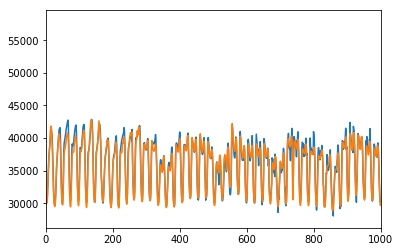

In [728]:
plt.plot(df_valid_tspred['usage'])
plt.plot(df_valid_tspred['30'])
_ = plt.xlim([0,1000])

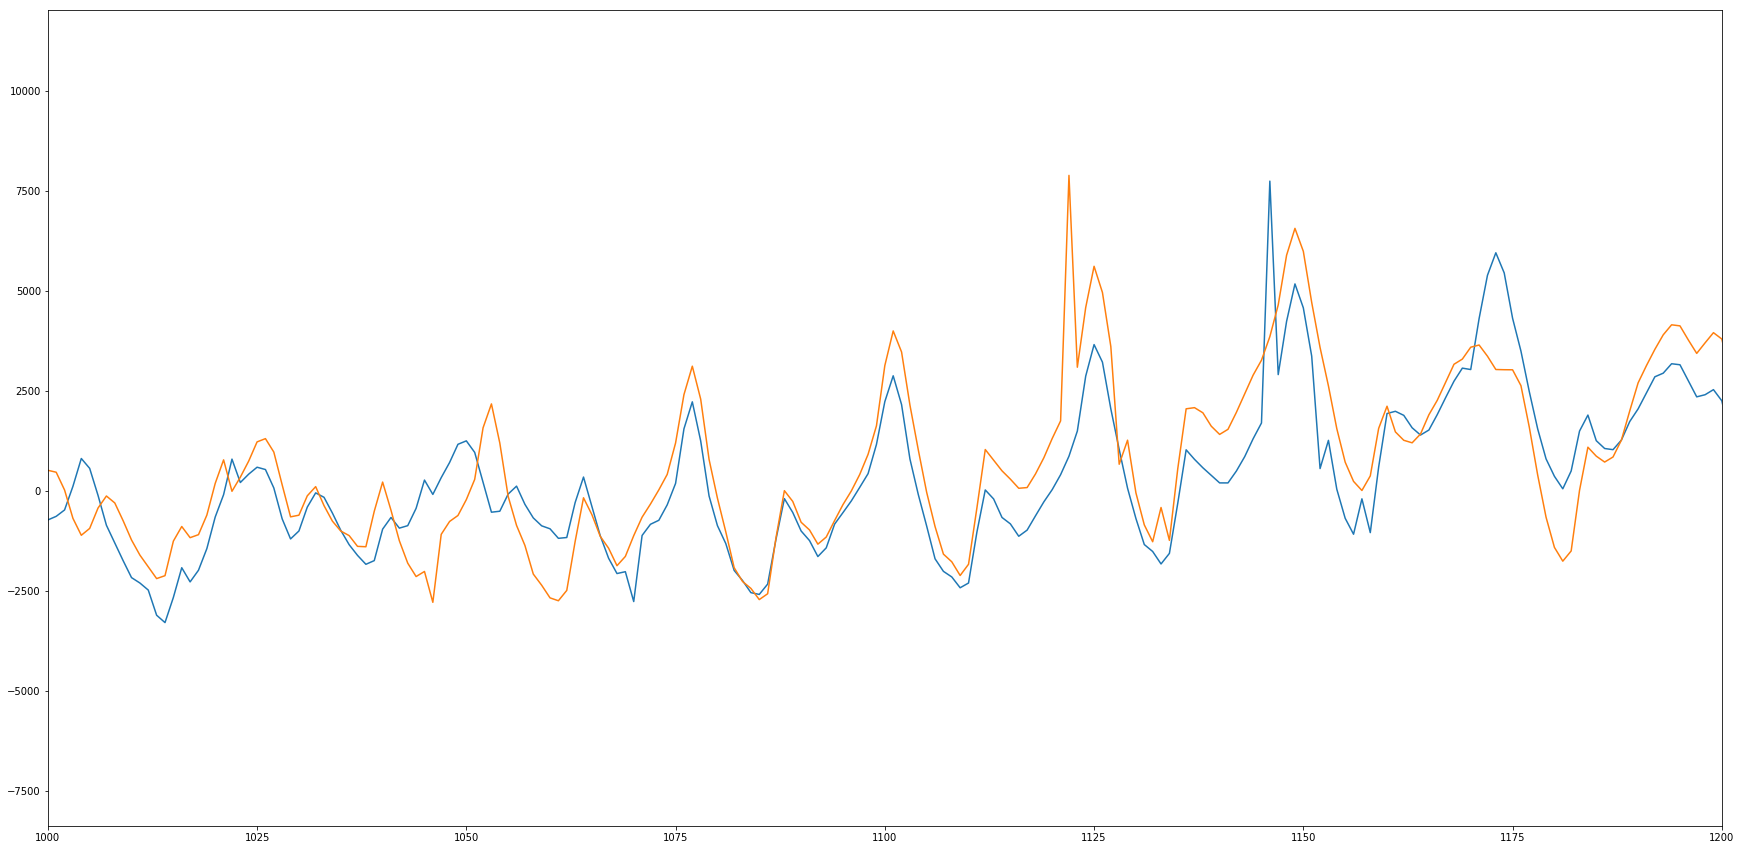

In [729]:
plt.subplots(figsize=(30,15))
plt.plot(df_valid_tspred['residual_pred'])
plt.plot(df_valid_tspred['residual'])
_ = plt.xlim(1000,1200)

r2_score: 0.9438735574139023


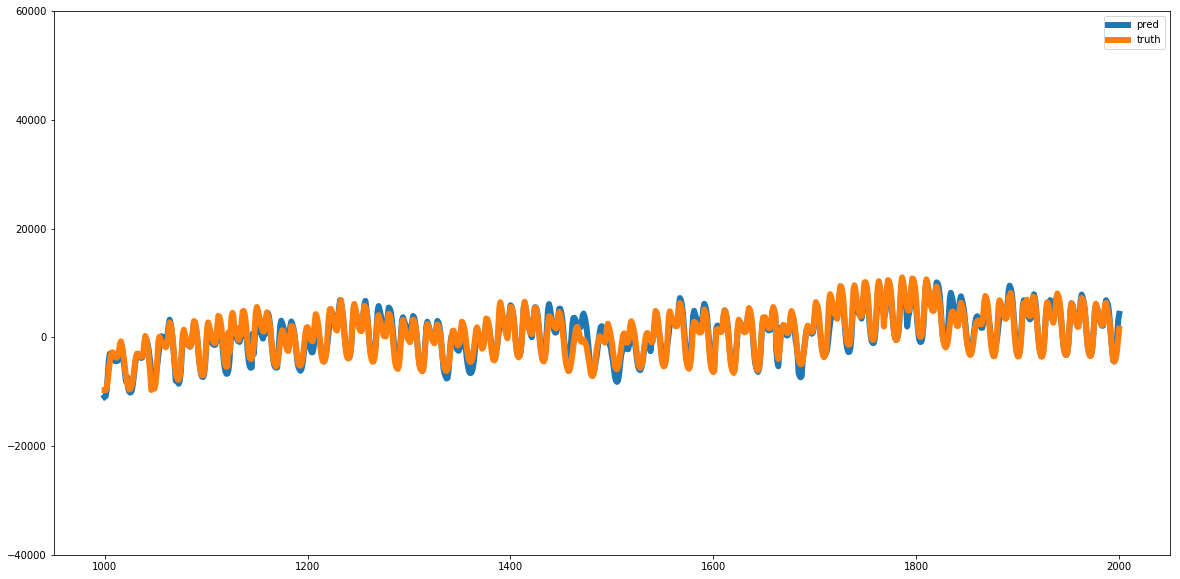

In [730]:
df_valid_tspred['ts_pred'] = df_valid_tspred['adjusted_pred']+df_valid_tspred['residual_pred']
# Remove all the Tuesday and Wednesday.
# df_valid_tspred = df_valid_tspred.loc[(df_valid_tspred['weekday'] != 1) & (df_valid_tspred['weekday'] != 2),:]
df_valid_tspred = df_valid_tspred.reset_index(drop=True)

print('r2_score: {}'.format(r2_score(df_valid_tspred['usage_trend_removed'], df_valid_tspred['ts_pred'])))

plt.subplots(figsize=(20,10))
plt.plot(df_valid_tspred.loc[1000:2000, 'ts_pred'], linewidth=6)
plt.plot(df_valid_tspred.loc[1000:2000, 'usage_trend_removed'], linewidth=6)
plt.ylim([-40000,60000])
plt.legend(['pred', 'truth'])
plt.show()

## Ensemble the random forest model and the time series model

In [731]:
df_train = df_train.reset_index(drop=True).rename(columns={'Unnamed: 0':'index'})
df_train = df_train.reset_index().rename(columns={'Unnamed: 0':'index'})
df_train = df_train.drop(columns=['index']).reset_index().rename(columns={'Unnamed: 0':'index'})
df_residual = predict_residual(df_train)
df_tspred_final = df_train.merge(df_residual, how='inner', left_on='index', right_on='index')

In [732]:
df_tspred_final.head(1)

,index,datetime,usage,time,month,weekday,year,day,hours,yearly_sin,yearly_cos,yearly_2_sin,yearly_2_cos,yearly_3_sin,yearly_3_cos,yearly_4_sin,yearly_4_cos,weekly_sin,weekly_cos,weekly_2_sin,weekly_2_cos,weekly_3_sin,weekly_3_cos,weekly_4_sin,weekly_4_cos,weekly_5_sin,weekly_5_cos,dayly_sin,dayly_cos,dayly_2_sin,dayly_2_cos,dayly_3_sin,dayly_3_cos,dayly_4_sin,dayly_4_cos,dayly_5_sin,dayly_5_cos,scaled_hours,scaled_hours_squared,scaled_hours_cubic,usage_trend_removed,prediction,date,adjusted_pred,residual,residual_pred,t_2,t_1
0,48,2015-07-03 01:06:00,36412,1,7,4,2015,3,48.016667,0.03441,0.999408,0.068779,0.997632,0.103067,0.994674,0.137233,0.990539,0.974789,-0.223129,-0.435007,-0.900427,-0.780664,0.624951,0.783384,0.621539,0.431074,-0.902317,0.004363,0.99999,0.008727,0.999962,0.01309,0.999914,0.017452,0.999848,0.021815,0.999762,0.480167,0.23056,0.110707,-1947.509811,-1622.464041,2015-07-03,-3673.695392,1726.18558,4095.945505,-22259.850732,1856.853883


In [733]:
# Y_pred = RF_model.predict(X_train).reshape(-1,1)
# Y_pred = LR_model.predict(XGB_model.predict(X_train).reshape(-1,1)).reshape(-1,1)
Y_pred = XGB_model.predict(X_train).reshape(-1,1)
df_tspred_final['rf_pred'] = Y_pred[24:]

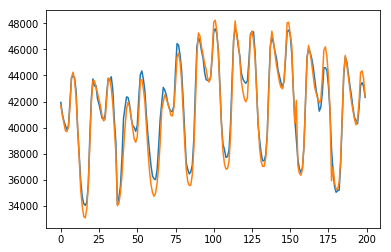

In [734]:
test_X = df_tspred_final['rf_pred'].values
test_y = df_tspred_final['usage'].values

plt.plot(test_X[5000:5200])
plt.plot(test_y[5000:5200])

In [735]:
def add_trend(row):
    return row['residual_pred']+row['adjusted_pred']+(row['scaled_hours']*linear_trend.coef_[0]+linear_trend.intercept_)*1e4

df_tspred_final['ts_pred'] = df_tspred_final.apply(lambda row: add_trend(row), axis=1)

In [736]:
def ts_or_rf(row):
    if abs(row['ts_pred']-row['usage']) <= abs(row['rf_pred']-row['usage']):
        return 1 # The time series model is better.
    else:
        return 0 # The random forest model is better
    
def ensemble_pred(row):
    if abs(row['ts_pred']-row['usage']) <= abs(row['rf_pred']-row['usage']):
        return row['ts_pred']
    else:
        return row['rf_pred']    

df_tspred_final['ts_or_rf'] = df_tspred_final.apply(lambda row: ts_or_rf(row), axis=1)
df_tspred_final['ensemble_pred'] = df_tspred_final.apply(lambda row: ensemble_pred(row), axis=1)

In [738]:
sum(df_tspred_final['ts_or_rf'] == 1)

13429

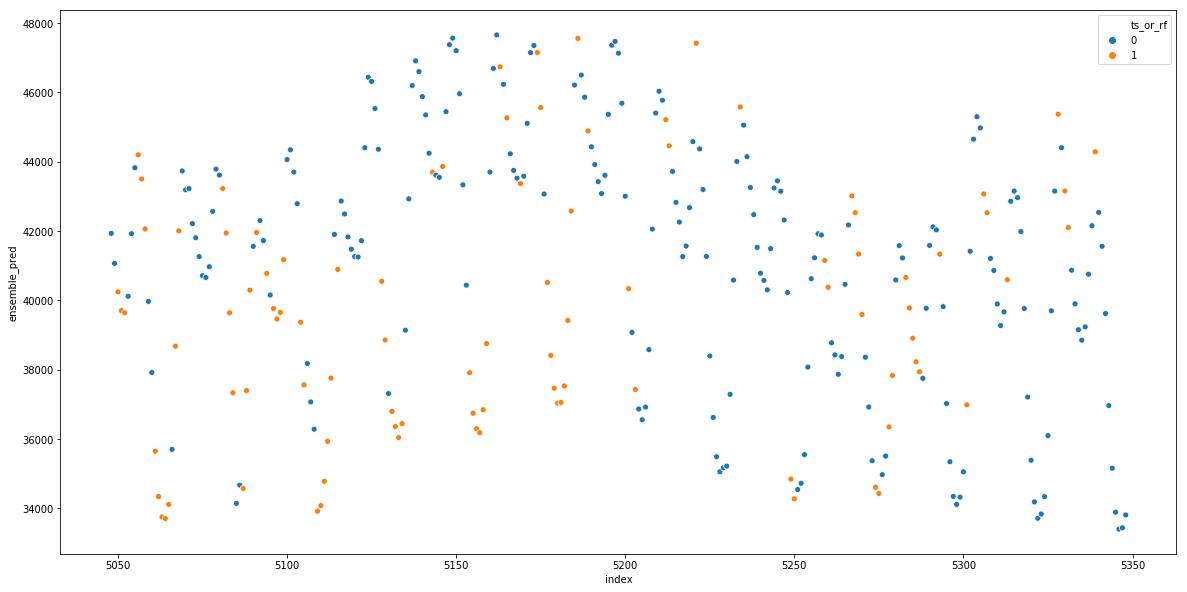

In [595]:
'''
plt.subplots(figsize=(20,10))
d = df_tspred_final.loc[df_tspred_final['ts_or_rf'] == 1, ['index', 'ts_pred']].values
plt.plot(df_tspred_final.loc[:300,'ts_pred'], 'b')
# d = df_tspred_final.loc[df_tspred_final['ts_or_rf'] == 0, ['index', 'ts_pred']].values
plt.plot(df_tspred_final.loc[:300,'rf_pred'], 'r')
plt.plot(df_tspred_final.loc[:300,'usage'], 'y')
# plt.xlim([48,500])
plt.show()
'''
plt.subplots(figsize=(20,10))
_ = sns.scatterplot(x='index', y='ensemble_pred', hue='ts_or_rf', data= df_tspred_final.loc[5000:5300,:])

In [739]:
X_temp = df_joined[features[3:]].values[:train_index,:]
X_temp = np.concatenate((X_temp[48:,:], X_temp[24:-24,:], X_temp[48,:]-X_temp[24:-24,:]), axis=1) # concatenate the temperatures 24 hours ago to the current temperature.

In [740]:
df_valid_tspred['ts_pred'] = df_valid_tspred.apply(lambda row: add_trend(row), axis=1)

In [741]:
df_valid_tspred['t2-t1'] = df_valid_tspred['t_2'] - df_valid_tspred['t_1']

In [742]:
df_valid_tspred.columns

Index(['index', 'datetime', 'usage', 'time', 'month', 'weekday', 'year', 'day',
       'hours', 'yearly_sin', 'yearly_cos', 'yearly_2_sin', 'yearly_2_cos',
       'yearly_3_sin', 'yearly_3_cos', 'yearly_4_sin', 'yearly_4_cos',
       'weekly_sin', 'weekly_cos', 'weekly_2_sin', 'weekly_2_cos',
       'weekly_3_sin', 'weekly_3_cos', 'weekly_4_sin', 'weekly_4_cos',
       'weekly_5_sin', 'weekly_5_cos', 'dayly_sin', 'dayly_cos', 'dayly_2_sin',
       'dayly_2_cos', 'dayly_3_sin', 'dayly_3_cos', 'dayly_4_sin',
       'dayly_4_cos', 'dayly_5_sin', 'dayly_5_cos', 'scaled_hours',
       'scaled_hours_squared', 'scaled_hours_cubic', 'usage_trend_removed',
       'prediction', 'adjusted_pred', 'residual', '0', '1', '2', '3', '4', '5',
       '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17',
       '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29',
       '30', 'residual_pred', 't_2', 't_1', 'ts_pred', 't2-t1'],
      dtype='object')

In [758]:
# So the ensemble model includes features: 'time', 'month', 'weekday', 'ts_pred', 'rf_pred', 'usage_last_day', 'usage_the_day_before_yesterday'
# 'difference_between_these_two', 'temperatures_last_day'*3, 'temperatures_the_day_before_last_day'*3, 'temperatures_difference'*3
# A random forest to ensemble the two methods.
grid = {}
X_ensemble = df_tspred_final[['time','month','weekday','ts_pred','rf_pred', 't_2', 't_1']].values
# Adding more and more features
# The difference between the two predictions
ts_rf_diff = X_ensemble[:,3]-X_ensemble[:,4]
X_ensemble = np.concatenate((X_ensemble, ts_rf_diff.reshape(-1,1), X_temp), axis=1)

Y_ensemble = df_tspred_final['usage'].values

rf_ensemble = RF(n_estimators=800, min_samples_split=4, min_samples_leaf=2, max_features=0.3,random_state=20).fit(X_ensemble, Y_ensemble)
# rf_ensemble = XGB(n_estimators=1000, max_depth=3, eta=0.3, objective='reg:squarederror', random_state=10).fit(X_ensemble, Y_ensemble)

# Construct the validation set
ensemble_features = ['time', 'month', 'weekday', 'ts_pred', '30', 't_2', 't_1', 't2-t1']
for extra in np.arange(30):
    ensemble_features.append(str(extra))
    
X_ensemble_valid = df_valid_tspred[ensemble_features].values[1:,:]
Y_ensemble_valid = df_valid_tspred['usage'].values[1:]

Y_pred_ensemble = rf_ensemble.predict(X_ensemble_valid)
print('r2_score: {}'.format(r2_score(Y_ensemble_valid, Y_pred_ensemble)))
print('original r2_score: {}'.format(r2_score(Y_ensemble_valid, X_ensemble_valid[:,4])))

r2_score: 0.978902746580442
original r2_score: 0.9522956139366392


In [750]:
X_ensemble_total = np.concatenate((X_ensemble, X_ensemble_valid),axis=0)
Y_ensemble_total = np.concatenate((Y_ensemble, Y_ensemble_valid))
ensemble_train_index = np.arange(len(X_ensemble))
ensemble_valid_index = np.arange(len(X_ensemble), len(X_ensemble_total))

grid = {'n_estimators': [200,800,1600],
       'min_samples_split': [2,4,8],
       'min_samples_leaf': [1,2,4],
       'max_features': [0.1,0.3,0.5,0.7],
       'random_state': [10]}

xgb_grid = {
        'objective':['reg:squarederror'],
        'n_estimators': [700,1000],
        'booster': ['gbtree'],
        'max_depth': [2,3,4],
        'eta': [0.1,0.3],
        'subsample': [0.4,0.7],
        'colsample_bynode': [0.7,1],
        'random_state': [10]
        }

ensemble_search = GridSearchCV(RF(), grid, cv=[(ensemble_train_index, ensemble_valid_index)], n_jobs=4, verbose=10)
_ = ensemble_search.fit(X_ensemble_total, Y_ensemble_total)

Fitting 1 folds for each of 108 candidates, totalling 108 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:  2.2min
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:  4.4min
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:  7.3min
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:  9.8min
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed: 19.8min
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed: 28.8min
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed: 38.6min
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed: 62.7min
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed: 87.4min
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed: 122.9min
[Parallel(n_jobs=4)]: Done 108 out of 108 | elapsed: 173.5min finished


In [751]:
ensemble_search.best_score_

0.979297281258975

In [756]:
ensemble_search.best_params_

{'max_features': 0.3,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 1600,
 'random_state': 10}

(0, 50000)

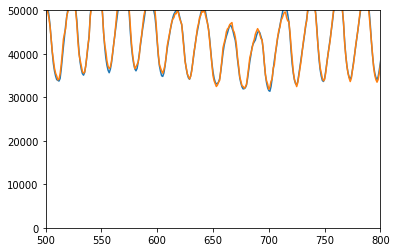

In [577]:
Y_pred_ensemble = ensemble_search.best_estimator_.predict(X_ensemble_valid)
# Y_pred_ensemble = rf_ensemble.predict(X_ensemble_valid)
plt.plot(Y_ensemble_valid)
# plt.plot(X_ensemble_valid[:,4])
plt.plot(Y_pred_ensemble)
# plt.plot(X_ensemble_valid[:,3])
# r2_score(Y_ensemble_valid, X_ensemble_valid[:,4])
plt.xlim([500,800])
plt.ylim([0,50000])

### Use the true valid set for validation

In [706]:
df_train.loc[:, 'pred'] = train_pred.reshape(-1)

df_train.loc[:, 'residual'] = df_train.loc[:, 'usage_trend_removed'] - df_train.loc[:, 'pred']

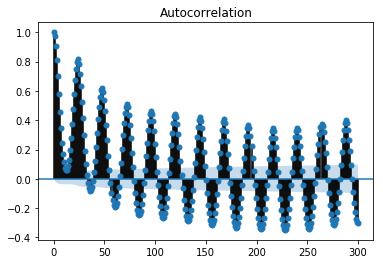

In [707]:
_ = plot_acf(df_train['residual'],lags=300)

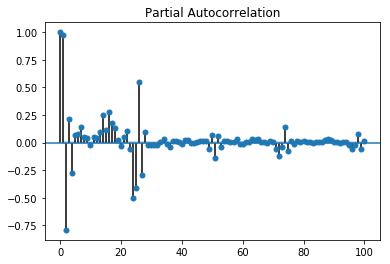

In [708]:
_ = plot_pacf(df_train['residual'],lags=100)

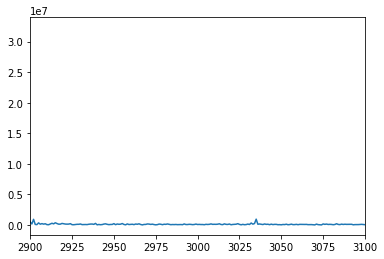

In [709]:
residual_fft = np.absolute(np.fft.fft(df_train['residual']))
plt.plot(residual_fft)
_ = plt.xlim([2900,3100])

In [270]:
len(df_train)

23175

In [275]:
23175/2/3.14*0.95

3505.7722929936303

In [274]:
np.arctan(1.4)

0.9505468408120751

In [277]:
23175/3030/24

0.3186881188118812

(-1, 70)

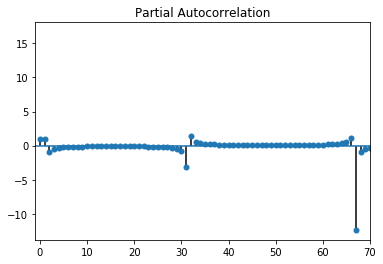

In [284]:
X = np.sin(np.arange(0,30,0.1))
_ = plot_pacf(X)
plt.xlim([-1,70])

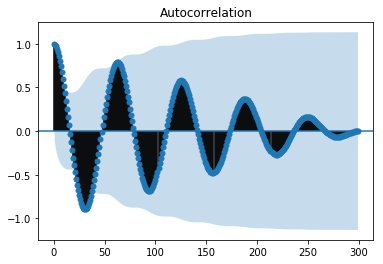

In [286]:
_ = plot_acf(X)

In [463]:
from statsmodels.tsa.stattools import ccf

In [486]:
ccf_1 = ccf(df_train['residual'], df_joined.iloc[:train_index]['T_Houston'])

(-0.2, 0.2)

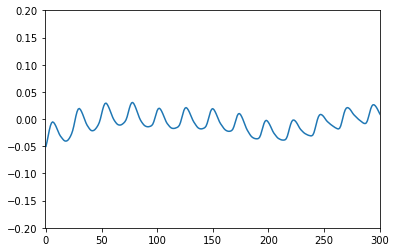

In [493]:
plt.plot(ccf_1)
plt.xlim([-1,300])
plt.ylim([-0.2,0.2])

In [482]:
5000/24

208.33333333333334

In [490]:
df_joined.head(1)

,datetime,usage,time,month,weekday,year,day,T_Houston,T_san_antonio,T_dallas
36934,2015-07-01 01:05:00,37456,1,7,2,2015,1,71.0,77.0,73.0


In [491]:
df_train.head(1)

,datetime,usage,time,month,weekday,year,day,hours,yearly_sin,yearly_cos,...,dayly_sin,dayly_cos,dayly_2_sin,dayly_2_cos,scaled_hours,scaled_hours_squared,scaled_hours_cubic,usage_trend_removed,residual,pred
0,2015-07-01 01:05:00,37456,1,7,2,2015,1,0.0,0.0,1.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,-1472.100301,-5889.020771,4416.92047


## Make prediction on the present data

In [710]:
# Load the electricity data from Sep 17 to Sep 24
elec_present = pd.read_csv('electricity_data/texas_sep_18.csv')

elec_present = elec_present.loc[:,['Timestamp (Hour Ending)', 'Demand (MWh)', 'Demand Forecast (MWh)']]
elec_present = elec_present.rename(columns={'Timestamp (Hour Ending)':'datetime','Demand (MWh)':'usage','Demand Forecast (MWh)':'prediction'})

elec_present['datetime'] = pd.to_datetime(elec_present['datetime'], format='%m/%d/%Y %I %p CDT')
elec_present['time'] = elec_present['datetime'].apply(lambda x:x.hour)
elec_present['month'] = elec_present['datetime'].apply(lambda x:x.month)
elec_present['weekday'] = elec_present['datetime'].apply(lambda x:x.weekday())
elec_present['year'] = elec_present['datetime'].apply(lambda x:x.year)
elec_present['day'] = elec_present['datetime'].apply(lambda x:x.day)

# Load the weather data
weather_sep_18 = pd.read_csv('electricity_data/weather_sep_18.csv')
# Round the date info
weather_sep_18['datetime'] = pd.to_datetime(weather_sep_18['DATE'], format='%Y-%m-%dT%H:%M:%S')
weather_sep_18['date'] = weather_sep_18['datetime'].apply(lambda date_time: round_time(date_time))
weather_sep_18['time'] = weather_sep_18['date'].apply(lambda x:x.hour)
weather_sep_18['month'] = weather_sep_18['date'].apply(lambda x:x.month)
weather_sep_18['day'] = weather_sep_18['date'].apply(lambda x:x.day)
# weather_sep_18['weekday'] = weather_sep_18['date'].apply(lambda x:x.weekday())
weather_sep_18['year'] = weather_sep_18['date'].apply(lambda x:x.year)
weather_sep_18['HourlyDryBulbTemperature'] = weather_sep_18['HourlyDryBulbTemperature'].apply(lambda s:parse_temperature(s))
weather_sep_18 = weather_sep_18.loc[weather_sep_18['HourlyDryBulbTemperature'].notna(),:]
weather_sep_18 = weather_sep_18[useful_columns]
weather_sep_18 = weather_sep_18[useful_columns].groupby(match_columns+['STATION'], as_index=False).mean()
houston = weather_sep_18.loc[weather_sep_18['STATION'] == 72243012960,:]
san_antonio = weather_sep_18.loc[weather_sep_18['STATION'] == 72259003927,:]
dallas = weather_sep_18.loc[weather_sep_18['STATION'] == 72253012921,:]
df_sep_18 = elec_present.merge(houston, how='inner', left_on=match_columns, right_on=match_columns)
df_sep_18 = df_sep_18.merge(san_antonio, how='inner', left_on=match_columns, right_on=match_columns)
df_sep_18 = df_sep_18.merge(dallas, how='inner', left_on=match_columns, right_on=match_columns)
df_sep_18 = df_sep_18.drop(columns=['STATION_x', 'STATION_y', 'STATION']).rename(columns={'HourlyDryBulbTemperature_x':'T_Houston','HourlyDryBulbTemperature_y':'T_san_antonio','HourlyDryBulbTemperature':'T_dallas'})
df_sep_18 = df_sep_18.sort_values('datetime').reset_index(drop=True)

In [711]:
df_sep_18['hours'] = df_sep_18['datetime'].apply(lambda x: diff_in_hours(x))
# Yearly period.
df_sep_18['yearly_sin'] = df_sep_18['hours'].apply(lambda x: trig(np.sin, 365.25*24, x))
df_sep_18['yearly_cos'] = df_sep_18['hours'].apply(lambda x: trig(np.cos, 365.25*24, x))
df_sep_18['yearly_2_sin'] = df_sep_18['hours'].apply(lambda x: trig(np.sin, 365.25*24/2, x)) # Starting from here are harmonics
df_sep_18['yearly_2_cos'] = df_sep_18['hours'].apply(lambda x: trig(np.cos, 365.25*24/2, x))
df_sep_18['yearly_3_sin'] = df_sep_18['hours'].apply(lambda x: trig(np.sin, 365.25*24/3, x))
df_sep_18['yearly_3_cos'] = df_sep_18['hours'].apply(lambda x: trig(np.cos, 365.25*24/3, x))
# Weekly period.
df_sep_18['weekly_sin'] = df_sep_18['hours'].apply(lambda x: trig(np.sin, 7*24, x))
df_sep_18['weekly_cos'] = df_sep_18['hours'].apply(lambda x: trig(np.cos, 7*24, x))
df_sep_18['weekly_2_sin'] = df_sep_18['hours'].apply(lambda x: trig(np.sin, 7*24/2, x))
df_sep_18['weekly_2_cos'] = df_sep_18['hours'].apply(lambda x: trig(np.cos, 7*24/2, x))
# Dayly period.
df_sep_18['dayly_sin'] = df_sep_18['hours'].apply(lambda x: trig(np.sin, 24, x))
df_sep_18['dayly_cos'] = df_sep_18['hours'].apply(lambda x: trig(np.cos, 24, x))
df_sep_18['dayly_2_sin'] = df_sep_18['hours'].apply(lambda x: trig(np.sin, 24/2, x))
df_sep_18['dayly_2_cos'] = df_sep_18['hours'].apply(lambda x: trig(np.cos, 24/2, x))
df_sep_18['dayly_3_sin'] = df_sep_18['hours'].apply(lambda x: trig(np.sin, 24/3, x))
df_sep_18['dayly_3_cos'] = df_sep_18['hours'].apply(lambda x: trig(np.cos, 24/3, x))
df_sep_18['dayly_4_sin'] = df_sep_18['hours'].apply(lambda x: trig(np.sin, 24/4, x))
df_sep_18['dayly_4_cos'] = df_sep_18['hours'].apply(lambda x: trig(np.cos, 24/4, x))

In [712]:
df_sep_18 = df_sep_18.reset_index().rename({'Unnamed: 0': 'index'})
df_sep_18.head(1)

,index,datetime,usage,prediction,time,month,weekday,year,day,T_Houston,...,weekly_2_sin,weekly_2_cos,dayly_sin,dayly_cos,dayly_2_sin,dayly_2_cos,dayly_3_sin,dayly_3_cos,dayly_4_sin,dayly_4_cos
0,0,2019-09-16,47548,47905.0,0,9,0,2019,16,76.0,...,0.439491,-0.898247,-0.021815,0.999762,-0.043619,0.999048,-0.065403,0.997859,-0.087156,0.996195


In [713]:
features = ['time', 'weekday', 'month', 'T_Houston', 'T_san_antonio', 'T_dallas']

In [714]:
# Produce the x^2 and X^3 term for the ridge regressor

df_sep_18['scaled_hours'] = df_sep_18['hours']/100
df_sep_18['scaled_hours_squared'] = df_sep_18['scaled_hours']**2
df_sep_18['scaled_hours_cubic'] = df_sep_18['scaled_hours']**3

df_sep_18['usage_trend_removed'] = df_sep_18[['usage','scaled_hours']].apply(lambda row: remove_trend(row), axis=1)

samples_X = df_sep_18.loc[:, columns_x].values
train_pred = period_model.predict(samples_X)
df_sep_18['web_pred'] = df_sep_18['prediction']
df_sep_18['prediction'] = train_pred

df_sep_18['adjusted_pred'] = df_sep_18['prediction']* \
                            lr_coef.predict(df_sep_18[columns_x[:6]].values).reshape(-1) \
                            + lr_intercept.predict(df_sep_18[columns_x[:6]].values).reshape(-1)

df_sep_18['residual'] = df_sep_18['usage_trend_removed']-df_sep_18['adjusted_pred']

index = np.arange(48, len(df_sep_18))
X_sep_18 = df_sep_18[features[3:]].values
x, y = attenuate(df_sep_18[features].values, df_sep_18['usage'].values, 0.84, 3)
# Y_pred_sep18 = my_estimator.predict(x, y)
Y_pred_sep18 = LR_model.predict(RF_model.predict(x).reshape(-1,1))
X_sep18 = np.concatenate((index.reshape(-1,1), X_sep_18[48:,:], X_sep_18[24:-24,:], X_sep_18[48,:]-X_sep_18[24:-24,:], Y_pred_sep18[24:].reshape(-1,1)), axis=1)
df_X_sep18 = pd.DataFrame(X_sep18, columns=['index', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9'])

df_residual = predict_residual(df_sep_18)
df_sep18_tspred = df_sep_18.merge(df_X_sep18, how='left', left_on='index', right_on='index')
df_sep18_tspred = df_sep18_tspred.merge(df_residual, how='inner', left_on='index', right_on='index')

In [715]:
df_sep18_tspred['ts_pred'] = df_sep18_tspred.apply(lambda row: add_trend(row), axis=1)
df_sep18_tspred['t2-t1'] = df_sep18_tspred['t_2'] - df_sep18_tspred['t_1']

X_ensemble_sep18 = df_sep18_tspred[ensemble_features].values
Y_ensemble_sep18 = df_sep18_tspred['usage'].values

# Y_sep18_pred = ensemble_search.best_estimator_.predict(X_ensemble_sep18)
Y_sep18_pred = rf_ensemble.predict(X_ensemble_sep18)

In [716]:
df_sep18_tspred.columns

Index(['index', 'datetime', 'usage', 'prediction', 'time', 'month', 'weekday',
       'year', 'day', 'T_Houston', 'T_san_antonio', 'T_dallas', 'hours',
       'yearly_sin', 'yearly_cos', 'yearly_2_sin', 'yearly_2_cos',
       'yearly_3_sin', 'yearly_3_cos', 'weekly_sin', 'weekly_cos',
       'weekly_2_sin', 'weekly_2_cos', 'dayly_sin', 'dayly_cos', 'dayly_2_sin',
       'dayly_2_cos', 'dayly_3_sin', 'dayly_3_cos', 'dayly_4_sin',
       'dayly_4_cos', 'scaled_hours', 'scaled_hours_squared',
       'scaled_hours_cubic', 'usage_trend_removed', 'web_pred',
       'adjusted_pred', 'residual', '0', '1', '2', '3', '4', '5', '6', '7',
       '8', '9', 'residual_pred', 't_2', 't_1', 'ts_pred', 't2-t1'],
      dtype='object')

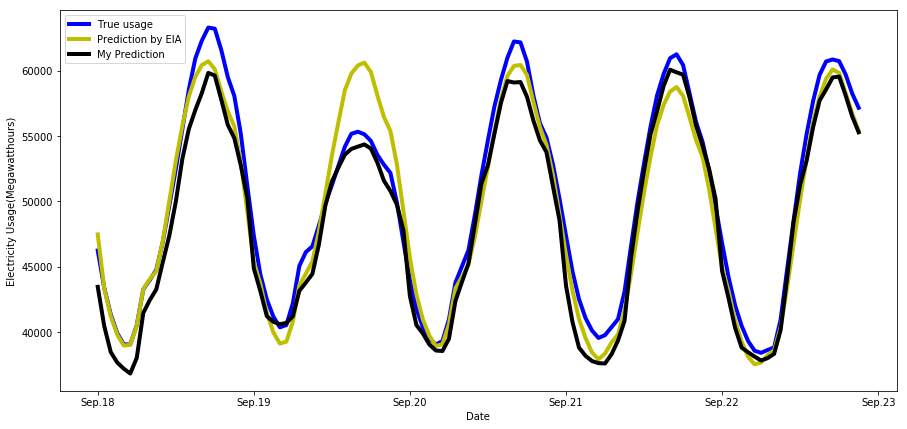

In [717]:
fig,ax = plt.subplots(figsize=(15,7))
plt.plot(Y_ensemble_sep18, 'b', linewidth=4)
plt.plot(df_sep18_tspred['web_pred'], 'y', linewidth=4)
plt.plot(Y_sep18_pred, 'black', linewidth=4)
plt.xlabel('Date')
plt.ylabel('Electricity Usage(Megawatthours)')
plt.legend(['True usage', 'Prediction by EIA', 'My Prediction'])
ax.xaxis.set_major_locator(MultipleLocator(24))
ax.set_xticklabels(['', 'Sep.18', 'Sep.19', 'Sep.20', 'Sep.21', 'Sep.22', 'Sep.23'])
plt.show()

In [759]:
# Save the ensemble model
with open('models/xgb_ensemble_NW_2', 'wb') as file:
    pickle.dump(rf_ensemble, file)